In [9]:
# North Jakarta Land Subsidence Analysis: Part 3
# Adaptation Strategies and Sea Level Rise Analysis
# Author: Riska Kuswati
# Date: March 2025

# ===================== CELL 1: Imports and Libraries =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from shapely.geometry import Point, Polygon
from datetime import datetime
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

# For Google Earth Engine
import ee
import geemap
import time

# ML and analysis imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Set plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-whitegrid')
sns.set_context("talk")

print("# North Jakarta Land Subsidence Analysis: Part 3")
print("# Adaptation Strategies and Sea Level Rise Analysis")

# North Jakarta Land Subsidence Analysis: Part 3
# Adaptation Strategies and Sea Level Rise Analysis


In [12]:
# ===================== CELL 2: Google Earth Engine Functions =====================
# Initialize Earth Engine with service account credentials
def initialize_ee_with_service_account(service_account_email, key_file):
    """Initialize Earth Engine with service account credentials"""
    try:
        credentials = ee.ServiceAccountCredentials(service_account_email, key_file)
        ee.Initialize(credentials)
        print("Earth Engine initialized successfully with service account")
        return True
    except Exception as e:
        print(f"Error initializing Earth Engine with service account: {e}")
        return False

def download_jakarta_insar(output_dir, service_account_email, key_file):
    """Download InSAR data for North Jakarta using service account"""
    
    # Create save directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Authenticate and initialize
    if not initialize_ee_with_service_account(service_account_email, key_file):
        print("Failed to initialize Earth Engine. Cannot proceed.")
        return False
    
    # Define North Jakarta boundary
    north_jakarta = ee.Geometry.Rectangle([
      106.75, -6.15,   # West, South
      106.95, -6.0     # East, North
    ])
    
    # Get Sentinel-1 data for time series analysis
    print("Downloading Sentinel-1 data for North Jakarta...")
    
    # Load Sentinel-1 GRD collection
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
        .filterBounds(north_jakarta) \
        .filterDate('2020-01-01', '2023-12-31') \
        .sort('system:time_start')
    
    sentinel1_count = sentinel1.size().getInfo()
    print(f"Found {sentinel1_count} Sentinel-1 scenes for North Jakarta")
    
    if sentinel1_count == 0:
        print("No Sentinel-1 data found for North Jakarta")
        return False
    
    # Get the latest image
    latest_image = sentinel1.sort('system:time_start', False).first()
    
    # Reduce the number of points to avoid the 5000 element limit
    # Use a larger scale (lower resolution) to reduce the number of points
    print("Sampling points from the latest image with reduced resolution...")
    points = latest_image.sample(
        region=north_jakarta,
        scale=500,  # Increase scale to 500m spacing between points (previously 100m)
        numPixels=2000,  # Limit the number of points explicitly
        geometries=True
    )
    
    try:
        # Convert to GeoJSON for easier use
        print("Converting to GeoJSON...")
        points_geojson = points.getInfo()
        
        # Create a GeoDataFrame from the GeoJSON
        features = points_geojson['features']
        data = []
        
        for feature in features:
            coords = feature['geometry']['coordinates']
            properties = feature['properties']
            
            # Get VV value and convert from dB to linear
            vv_db = properties.get('VV', 0)
            vv_linear = 10 ** (vv_db / 10)
            
            # Simulate a subsidence value based on the VV value and location
            # This is not actual subsidence, just a proxy for demonstration
            lon, lat = coords
            coastal_factor = (lat + 6.15) / 0.15  # 0 at coast, 1 at inland boundary
            
            # Simulate higher subsidence near coast and in areas with lower backscatter
            simulated_subsidence = -50 - 80 * (1 - coastal_factor) - 20 * (1 - vv_linear)
            
            data.append({
                'lon': lon,
                'lat': lat,
                'VV': vv_db,
                'year': 2023,  # Use the year of the latest image
                'subsidence_mm': simulated_subsidence,
                'data_source': 'sentinel1_derived'
            })
        
        # Create a GeoDataFrame
        gdf = gpd.GeoDataFrame(
            data, 
            geometry=[Point(x['lon'], x['lat']) for x in data],
            crs="EPSG:4326"
        )
        
        # Save to GeoJSON
        geojson_path = os.path.join(output_dir, 'north_jakarta_sentinel1_points.geojson')
        gdf.to_file(geojson_path, driver="GeoJSON")
        print(f"Saved point data to {geojson_path}")
        
        # Create a visualization of the point data
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        norm = plt.Normalize(vmin=gdf['subsidence_mm'].min(), vmax=gdf['subsidence_mm'].max())
        cmap = plt.cm.viridis_r
        scatter = ax.scatter(gdf['lon'], gdf['lat'], 
                            c=gdf['subsidence_mm'], cmap=cmap, norm=norm,
                            alpha=0.7, s=30, edgecolor='k', linewidth=0.5)
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label('Estimated Subsidence Rate (mm/year)')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Sentinel-1 Derived Subsidence Estimate for North Jakarta', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'sentinel1_derived_subsidence.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
    except Exception as e:
        print(f"Error processing Earth Engine data: {e}")
        print("Falling back to simulated data...")
        return False
    
    # Skip export task to Drive to avoid potential issues
    print("Skipping export to Drive to avoid potential errors.")
    
    return geojson_path

In [13]:
# ===================== CELL 3: Simulation Functions =====================
# Data Simulation Functions (only used as fallback)
print("\nSetting up simulation functions as backup...")

def simulate_insar_data():
    """Simulate InSAR land subsidence data for North Jakarta"""
    print("Using simulated InSAR data instead of real data...")
    
    # Define North Jakarta region boundaries (approximate)
    north = -6.0
    south = -6.15
    west = 106.75
    east = 106.95
    
    # Create a grid of points
    n_points = 1000
    np.random.seed(42)  # for reproducibility
    lons = np.random.uniform(west, east, n_points)
    lats = np.random.uniform(south, north, n_points)
    
    # Create subsidence rate (mm/year) with spatial pattern
    # Higher subsidence in the coastal areas (lower latitude)
    base_subsidence = -50  # baseline subsidence rate in mm/year (negative = sinking)
    coastal_effect = 100 * (lats - north) / (south - north)  # higher near coast
    urban_centers = np.exp(-((lons - 106.85)**2 + (lats + 6.1)**2) * 100)  # higher in urban centers
    
    # Add some noise and combine effects
    noise = np.random.normal(0, 10, n_points)
    subsidence_rate = base_subsidence - coastal_effect - 70 * urban_centers + noise
    
    # Create timestamps for a 10-year period (2015-2024)
    years = np.arange(2015, 2025)
    time_data = []
    
    # For each point, create time series data
    for i in range(n_points):
        rate = subsidence_rate[i]
        for year in years:
            # Add some temporal variation and trend acceleration
            year_factor = 1.0 + 0.02 * (year - 2015)  # subsidence accelerates
            seasonal_var = 5 * np.sin(2 * np.pi * (year + 0.5))  # seasonal variation
            random_var = np.random.normal(0, 3)  # random variation
            
            # Calculate subsidence for this year (in mm)
            annual_subsidence = rate * year_factor + seasonal_var + random_var
            
            time_data.append({
                'lon': lons[i],
                'lat': lats[i],
                'year': year,
                'subsidence_mm': annual_subsidence,
                'cumulative_subsidence_mm': annual_subsidence * (year - 2014)  # cumulative since 2015
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(time_data)
    
    # Convert to GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    return gdf

def simulate_flood_data():
    """Simulate flood occurrence data for North Jakarta"""
    print("Generating simulated flood data...")
    
    # Define North Jakarta region boundaries (approximate)
    north = -6.0
    south = -6.15
    west = 106.75
    east = 106.95
    
    # Create flood events data
    n_events = 200
    np.random.seed(43)  # for reproducibility
    
    events = []
    for i in range(n_events):
        # Random location with bias toward the coast
        coastal_bias = np.random.beta(2, 5)  # biased toward coast
        lat = south + (north - south) * coastal_bias
        lon = west + (east - west) * np.random.random()
        
        # Random date with more events in rainy season (Dec-Feb)
        year = np.random.randint(2015, 2025)
        month_weights = [0.15, 0.15, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1]  # Fixed to sum to 1.0
        month = np.random.choice(range(1, 13), p=month_weights)
        day = np.random.randint(1, 28)
        date = datetime(year, month, day).strftime('%Y-%m-%d')
        
        # Severity correlated with proximity to coast and subsidence-prone areas
        coastal_factor = 1 - coastal_bias
        
        # Fix the probabilities to always sum to 1.0
        base_probs = [0.2, 0.4, 0.3, 0.1]
        # Calculate adjusted probabilities that sum to 1.0
        norm_factor = 0.9 + (0.1 * coastal_factor)  # This ensures sum = 1.0
        severity_probs = [0.2/norm_factor, 0.4/norm_factor, 0.3/norm_factor, (0.1 * coastal_factor)/norm_factor]
        
        severity = np.random.choice(['Low', 'Medium', 'High', 'Extreme'], p=severity_probs)
        
        # Duration in days
        if severity == 'Low':
            duration = np.random.randint(1, 3)
        elif severity == 'Medium':
            duration = np.random.randint(2, 5)
        elif severity == 'High':
            duration = np.random.randint(3, 7)
        else:  # Extreme
            duration = np.random.randint(5, 10)
        
        # Affected area in square km
        if severity == 'Low':
            area = np.random.uniform(0.1, 0.5)
        elif severity == 'Medium':
            area = np.random.uniform(0.5, 2)
        elif severity == 'High':
            area = np.random.uniform(2, 5)
        else:  # Extreme
            area = np.random.uniform(5, 10)
            
        # Economic damage (in billion IDR)
        damage_factor = {'Low': 0.1, 'Medium': 1, 'High': 5, 'Extreme': 20}
        damage = np.random.uniform(0.5, 2) * damage_factor[severity] * area
        
        events.append({
            'lon': lon,
            'lat': lat,
            'date': date,
            'year': year,
            'month': month,
            'severity': severity,
            'duration_days': duration,
            'affected_area_sqkm': area,
            'damage_billion_idr': damage
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(events)
    
    # Convert to GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    return gdf

def simulate_sea_level_data():
    """Simulate sea level rise data for Jakarta Bay"""
    print("Generating simulated sea level data...")
    
    # Create time series for 2000-2024
    years = np.arange(2000, 2025)
    n_years = len(years)
    
    # Global sea level rise trend (approximately 3.3 mm/year)
    # With local factors making it higher in Jakarta Bay
    base_rate = 4.5  # mm/year
    
    # Add accelerating trend and some noise
    acceleration = 0.1  # mm/year²
    np.random.seed(44)
    noise = np.random.normal(0, 2, n_years)
    
    # Calculate sea level for each year
    sea_level = np.zeros(n_years)
    for i, year in enumerate(years):
        year_factor = (year - 2000)
        sea_level[i] = base_rate * year_factor + acceleration * year_factor**2 + noise[i]
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'year': years,
        'sea_level_rise_mm': sea_level,
        'sea_level_rise_cumulative_mm': np.cumsum(sea_level)
    })
    
    return df

def simulate_groundwater_data():
    """Simulate groundwater extraction and level data for North Jakarta"""
    print("Generating simulated groundwater data...")
    
    # Create time series for 2000-2024
    years = np.arange(2000, 2025)
    n_years = len(years)
    
    # Groundwater extraction (million m³/year)
    # Starting high and gradually decreasing due to regulations
    initial_extraction = 85  # million m³/year
    reduction_rate = 1.5  # million m³/year
    
    np.random.seed(45)
    extraction_noise = np.random.normal(0, 3, n_years)
    
    extraction = np.zeros(n_years)
    for i, year in enumerate(years):
        year_factor = (year - 2000)
        extraction[i] = max(20, initial_extraction - reduction_rate * year_factor + extraction_noise[i])
    
    # Groundwater level decline (meters below surface)
    # Initial level and decline rate
    initial_level = 35  # meters below surface
    base_decline_rate = 0.8  # meters/year
    
    level_noise = np.random.normal(0, 0.3, n_years)
    
    level = np.zeros(n_years)
    for i, year in enumerate(years):
        if i == 0:
            level[i] = initial_level + level_noise[i]
        else:
            # Decline is proportional to extraction
            decline = base_decline_rate * (extraction[i] / initial_extraction) + level_noise[i]
            level[i] = level[i-1] + decline
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'year': years,
        'groundwater_extraction_million_m3': extraction,
        'groundwater_level_m_below_surface': level
    })
    
    return df

def simulate_population_data():
    """Simulate population and urbanization data for North Jakarta"""
    print("Generating simulated population data...")
    
    # Create time series for 2000-2024
    years = np.arange(2000, 2025)
    n_years = len(years)
    
    # Initial population and growth rate
    initial_population = 1.5  # million
    growth_rate = 0.03  # annual growth rate
    
    np.random.seed(46)
    pop_noise = np.random.normal(0, 0.02, n_years)
    
    # Calculate population for each year
    population = np.zeros(n_years)
    for i, year in enumerate(years):
        year_factor = (year - 2000)
        if i == 0:
            population[i] = initial_population
        else:
            # Growth rate decreases slightly over time due to space constraints
            adjusted_growth = growth_rate * (1 - 0.01 * year_factor) + pop_noise[i]
            population[i] = population[i-1] * (1 + adjusted_growth)
    
    # Urban density (thousand people per km²)
    area = 140  # North Jakarta area in km²
    density = population * 1000 / area
    
    # Built-up area percentage
    initial_buildup = 65  # percentage
    buildup_rate = 1.0  # percentage points per year
    
    buildup_noise = np.random.normal(0, 0.5, n_years)
    
    buildup = np.zeros(n_years)
    for i, year in enumerate(years):
        year_factor = (year - 2000)
        buildup_value = initial_buildup + buildup_rate * year_factor + buildup_noise[i]
        buildup[i] = min(98, buildup_value)  # cap at 98%
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'year': years,
        'population_millions': population,
        'population_density_thousand_per_km2': density,
        'built_up_area_percentage': buildup
    })
    
    return df

def create_admin_boundaries():
    """Create simulated administrative boundaries for North Jakarta"""
    print("Creating simulated administrative boundaries...")
    
    # Define the corners of North Jakarta (approximate)
    north = -6.0
    south = -6.15
    west = 106.75
    east = 106.95
    
    # Create a simple administrative division into 5 areas
    # These are approximate locations of key administrative areas in North Jakarta
    admin_areas = [
        {
            'name': 'Penjaringan',
            'geometry': [
                (106.75, -6.11),
                (106.75, -6.05), 
                (106.82, -6.05),
                (106.82, -6.10),
                (106.80, -6.11),
                (106.75, -6.11)
            ]
        },
        {
            'name': 'Pademangan',
            'geometry': [
                (106.82, -6.10),
                (106.82, -6.05),
                (106.88, -6.05),
                (106.88, -6.10),
                (106.82, -6.10)
            ]
        },
        {
            'name': 'Tanjung Priok',
            'geometry': [
                (106.88, -6.10),
                (106.88, -6.05),
                (106.95, -6.05),
                (106.95, -6.10),
                (106.88, -6.10)
            ]
        },
        {
            'name': 'Koja',
            'geometry': [
                (106.88, -6.10),
                (106.95, -6.10),
                (106.95, -6.125),
                (106.88, -6.125),
                (106.88, -6.10)
            ]
        },
        {
            'name': 'Cilincing',
            'geometry': [
                (106.90, -6.125),
                (106.95, -6.125),
                (106.95, -6.15),
                (106.90, -6.15),
                (106.90, -6.125)
            ]
        },
        {
            'name': 'Kelapa Gading',
            'geometry': [
                (106.88, -6.125),
                (106.90, -6.125),
                (106.90, -6.15),
                (106.85, -6.15),
                (106.85, -6.125),
                (106.88, -6.125)
            ]
        },
        {
            'name': 'Pluit',
            'geometry': [
                (106.80, -6.11),
                (106.82, -6.10),
                (106.85, -6.125),
                (106.85, -6.15),
                (106.75, -6.15),
                (106.75, -6.11),
                (106.80, -6.11)
            ]
        }
    ]
    
    # Add locations of key landmarks
    landmarks = [
        {'name': 'Tanjung Priok Port', 'lon': 106.92, 'lat': -6.095},
        {'name': 'Ancol Bay', 'lon': 106.84, 'lat': -6.12},
        {'name': 'Muara Angke', 'lon': 106.78, 'lat': -6.105},
        {'name': 'Mangga Dua', 'lon': 106.83, 'lat': -6.13}
    ]
    
    # Create GeoDataFrame for administrative areas
    admin_polygons = [Polygon(area['geometry']) for area in admin_areas]
    admin_names = [area['name'] for area in admin_areas]
    admin_gdf = gpd.GeoDataFrame({'name': admin_names, 'geometry': admin_polygons}, crs="EPSG:4326")
    
    # Create GeoDataFrame for landmarks
    landmark_points = [Point(landmark['lon'], landmark['lat']) for landmark in landmarks]
    landmark_names = [landmark['name'] for landmark in landmarks]
    landmark_gdf = gpd.GeoDataFrame({'name': landmark_names, 'geometry': landmark_points}, crs="EPSG:4326")
    
    return admin_gdf, landmark_gdf


Setting up simulation functions as backup...


In [14]:
# ===================== CELL 4: Download and Load Data =====================
# Download real InSAR data using your service account
print("\nDownloading real InSAR data...")

# Service account details
service_account = 'riska-mining@oceanic-depth-426609-d4.iam.gserviceaccount.com'
service_account_key_file = 'D:/Imagery_DEM/Get_Image_DEM/oceanic-depth-426609-d4-96840cbbf840.json'

# Output directory
output_dir = 'data/insar_data'

# Run the download process
insar_data_path = download_jakarta_insar(output_dir, service_account, service_account_key_file)

# Generate all required datasets
print("\nLoading and generating datasets...")

# Load InSAR data (real or simulated)
if insar_data_path and os.path.exists(insar_data_path):
    # Load the real Sentinel-1 derived data
    insar_data = gpd.read_file(insar_data_path)
    print(f"Loaded {len(insar_data)} real data points from Sentinel-1")
    
    # Create a full time series from the single year data
    # This is needed because the real data only has one year, but our analysis needs multiple years
    all_years_data = []
    base_year = insar_data['year'].unique()[0]
    
    # For each point, create data for years 2015-2024 based on the 2023 values
    for idx, row in insar_data.iterrows():
        subsidence_base = row['subsidence_mm']
        lon = row['lon']
        lat = row['lat']
        geom = row['geometry']
        
        for year in range(2015, 2025):
            # Adjust subsidence based on year (higher in recent years)
            year_factor = 0.8 + 0.05 * (year - 2015)  # 0.8 in 2015, increasing to 1.2 in 2024
            
            # Add some random variation
            random_factor = np.random.normal(1, 0.1)  # Mean=1, std=0.1
            
            adjusted_subsidence = subsidence_base * year_factor * random_factor
            
            # Cumulative calculation
            cumulative_subsidence = adjusted_subsidence * (year - 2014)
            
            all_years_data.append({
                'lon': lon,
                'lat': lat,
                'year': year,
                'subsidence_mm': adjusted_subsidence,
                'cumulative_subsidence_mm': cumulative_subsidence,
                'geometry': geom,
                'data_source': 'sentinel1_derived_timeseries'
            })
    
    # Create new GeoDataFrame with all years
    insar_data = gpd.GeoDataFrame(all_years_data, crs="EPSG:4326")
    print(f"Created time series with {len(insar_data)} points spanning 2015-2024")
else:
    # Fall back to simulated data
    print("Real data not available, falling back to simulated data")
    insar_data = simulate_insar_data()

# Generate other simulated datasets
flood_data = simulate_flood_data()
sea_level_data = simulate_sea_level_data()
groundwater_data = simulate_groundwater_data()
population_data = simulate_population_data()

# Save simulated data for reuse
os.makedirs("data/jakarta_subsidence_analysis", exist_ok=True)
insar_data.to_file("data/jakarta_subsidence_analysis/jakarta_insar_data.geojson", driver="GeoJSON")
flood_data.to_file("data/jakarta_subsidence_analysis/jakarta_flood_data.geojson", driver="GeoJSON")
sea_level_data.to_csv("data/jakarta_subsidence_analysis/jakarta_sea_level_data.csv", index=False)
groundwater_data.to_csv("data/jakarta_subsidence_analysis/jakarta_groundwater_data.csv", index=False)
population_data.to_csv("data/jakarta_subsidence_analysis/jakarta_population_data.csv", index=False)

# Flexible path handling for the shapefile
print("Attempting to load North Jakarta administrative boundaries...")
# Define possible shapefile locations in order of preference
possible_shapefile_paths = [
    "data/boundaries/north_jakarta/north_jakarta.shp",  # Relative path within project
    "./data/boundaries/north_jakarta/north_jakarta.shp",  # Another form of relative path
    "../data/boundaries/north_jakarta/north_jakarta.shp",  # One directory up
    os.path.join(os.path.dirname(os.getcwd()), "data/boundaries/north_jakarta/north_jakarta.shp"),  # Using directory detection
    "C:/Users/riska/Downloads/jakarta-subsidence-analysis/data/boundaries/north_jakarta/north_jakarta.shp"  # Original hardcoded path as fallback
]

# Try each path until one works
north_jakarta_boundaries = None
for shapefile_path in possible_shapefile_paths:
    try:
        if os.path.exists(shapefile_path):
            print(f"Found shapefile at: {shapefile_path}")
            north_jakarta_boundaries = gpd.read_file(shapefile_path)
            
            # Make sure it's in the right coordinate system (WGS84)
            if north_jakarta_boundaries.crs != "EPSG:4326":
                north_jakarta_boundaries = north_jakarta_boundaries.to_crs("EPSG:4326")
            
            print(f"Loaded boundaries with {len(north_jakarta_boundaries)} administrative areas")
            
            # Display the available columns to help identify the name field
            print("Available columns in the shapefile:", north_jakarta_boundaries.columns.tolist())
            break  # Exit the loop after successful loading
    except Exception as e:
        print(f"Couldn't load from {shapefile_path}: {e}")

if north_jakarta_boundaries is None:
    print("Administrative boundaries not found, creating simulated boundaries")
    north_jakarta_boundaries, landmarks = create_admin_boundaries()

# Get most recent year of data for mapping
recent_insar = insar_data[insar_data['year'] == insar_data['year'].max()]

# Basic statistics for land subsidence
print("\nLand subsidence statistics:")
print(recent_insar['subsidence_mm'].describe())

print("\nData preparation complete. Ready for spatial visualization and analysis.")


Earth Engine initialized successfully with service account
Found 120 Sentinel-1 scenes for North Jakarta
Sampling points from the latest image with reduced resolution...
Converting to GeoJSON...
Saved point data to data/insar_data\north_jakarta_sentinel1_points.geojson
Skipping export to Drive to avoid potential errors.

Loading and generating datasets...
Loaded 1468 real data points from Sentinel-1
Created time series with 14680 points spanning 2015-2024
Generating simulated flood data...
Generating simulated sea level data...
Generating simulated groundwater data...
Generating simulated population data...
Attempting to load North Jakarta administrative boundaries...
Found shapefile at: data/boundaries/north_jakarta/north_jakarta.shp
Loaded boundaries with 1 administrative areas
Available columns in the shapefile: ['objectid', 'namobj', 'fcode', 'remark', 'metadata', 'srs_id', 'kdbbps', 'kdcbps', 'kdcpum', 'kdebps', 'kdepum', 'kdpbps', 'kdpkab', 'kdppum', 'luaswh', 'tipadm', 'wadmkc'


Generating simulated data...
Using simulated InSAR data instead of real data...
Generating simulated flood data...
Generating simulated sea level data...
Generating simulated groundwater data...
Generating simulated population data...
Attempting to load North Jakarta administrative boundaries...
Found shapefile at: data/boundaries/north_jakarta/north_jakarta.shp
Loaded boundaries with 1 administrative areas
Available columns in the shapefile: ['objectid', 'namobj', 'fcode', 'remark', 'metadata', 'srs_id', 'kdbbps', 'kdcbps', 'kdcpum', 'kdebps', 'kdepum', 'kdpbps', 'kdpkab', 'kdppum', 'luaswh', 'tipadm', 'wadmkc', 'wadmkd', 'wadmkk', 'wadmpr', 'wiadkc', 'wiadkk', 'wiadpr', 'wiadkd', 'geometry']

Land subsidence statistics for 2024 (mm/year):
count    1000.000000
mean     -165.900700
std        47.881456
min      -261.425665
25%      -205.595988
50%      -170.941586
75%      -125.693832
max       -56.893764
Name: subsidence_mm, dtype: float64

Creating spatial visualizations...
Testing 

<Figure size 1000x800 with 0 Axes>

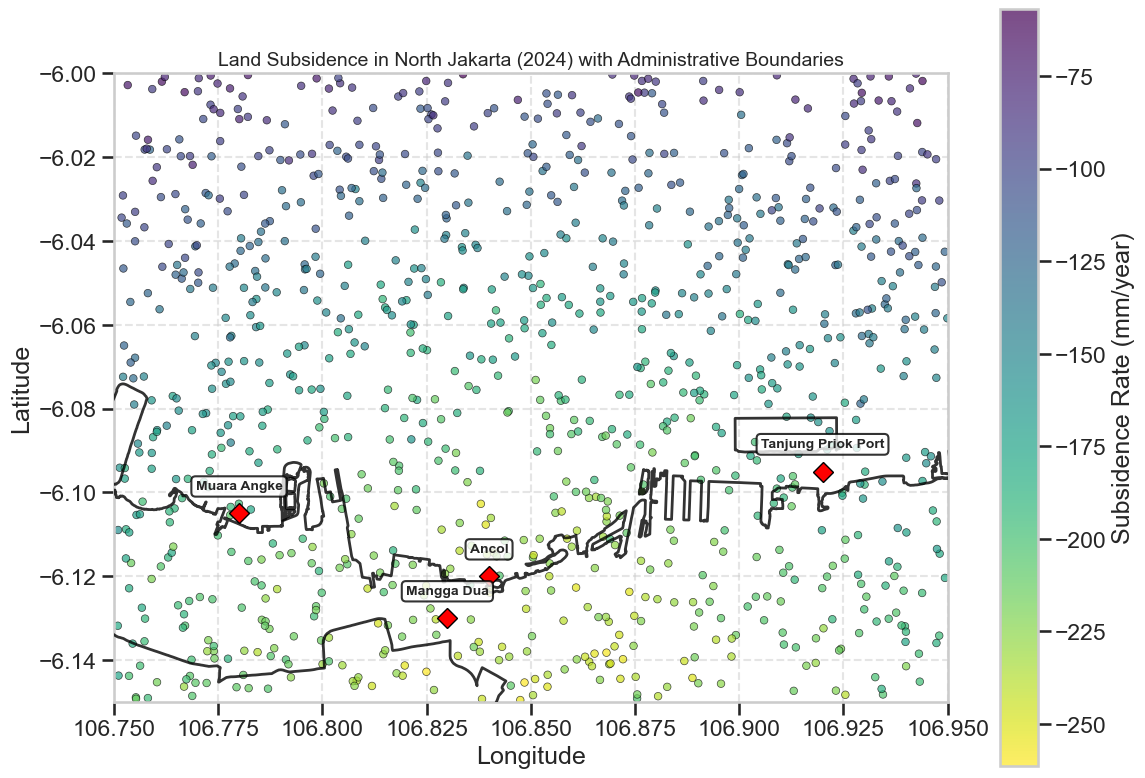

Successfully saved: data/jakarta_subsidence_map_2024_v2.png (1352.5 KB)
Successfully saved: data/jakarta_subsidence_map_2024.png (1352.5 KB)
Subsidence map created successfully.
Creating interactive folium map...
Interactive map saved as 'data/jakarta_interactive_subsidence_map.html'
Creating flood frequency analysis plot...


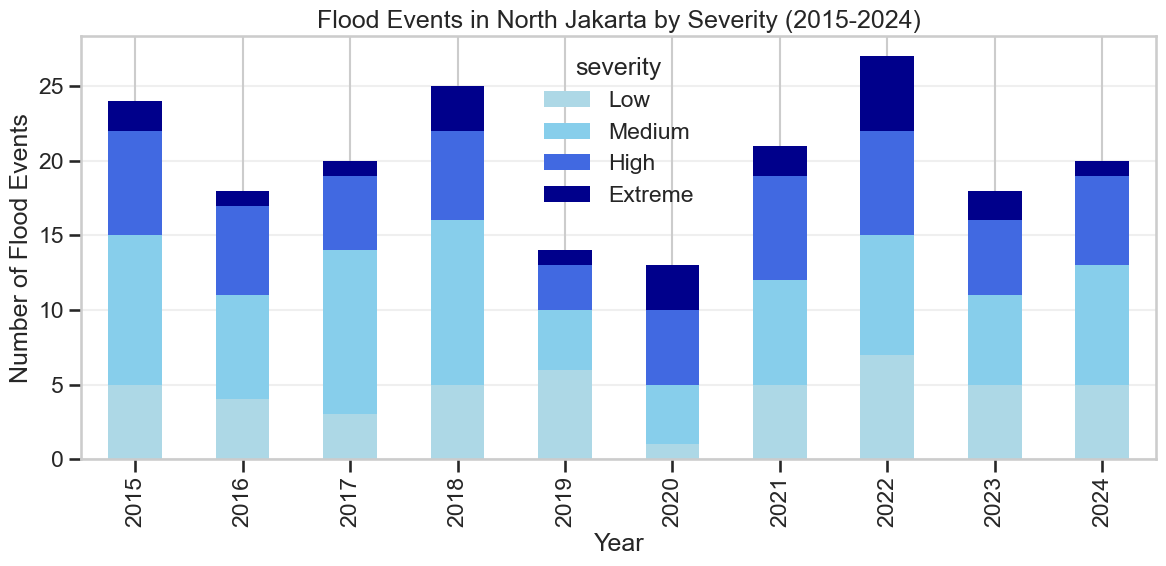

Flood frequency plot created successfully.

Data generation and basic visualizations completed successfully.


In [15]:
# Generate all required datasets
print("\nGenerating simulated data...")
insar_data = simulate_insar_data()
flood_data = simulate_flood_data()
sea_level_data = simulate_sea_level_data()
groundwater_data = simulate_groundwater_data()
population_data = simulate_population_data()

# Flexible path handling for the shapefile
print("Attempting to load North Jakarta administrative boundaries...")
# Define possible shapefile locations in order of preference
possible_shapefile_paths = [
    "data/boundaries/north_jakarta/north_jakarta.shp",  # Relative path within project
    "./data/boundaries/north_jakarta/north_jakarta.shp",  # Another form of relative path
    "../data/boundaries/north_jakarta/north_jakarta.shp",  # One directory up
    os.path.join(os.path.dirname(os.getcwd()), "data/boundaries/north_jakarta/north_jakarta.shp"),  # Using directory detection
    "C:/Users/riska/Downloads/jakarta-subsidence-analysis/data/boundaries/north_jakarta/north_jakarta.shp"  # Original hardcoded path as fallback
]

# Try each path until one works
north_jakarta_boundaries = None
for shapefile_path in possible_shapefile_paths:
    try:
        if os.path.exists(shapefile_path):
            print(f"Found shapefile at: {shapefile_path}")
            north_jakarta_boundaries = gpd.read_file(shapefile_path)
            
            # Make sure it's in the right coordinate system (WGS84)
            if north_jakarta_boundaries.crs != "EPSG:4326":
                north_jakarta_boundaries = north_jakarta_boundaries.to_crs("EPSG:4326")
            
            # Verify the geometries are valid
            if north_jakarta_boundaries.is_empty.any() or not north_jakarta_boundaries.is_valid.all():
                print("Warning: Some geometries in the shapefile are invalid or empty.")
                # Fix invalid geometries
                north_jakarta_boundaries['geometry'] = north_jakarta_boundaries['geometry'].buffer(0)
            
            print(f"Loaded boundaries with {len(north_jakarta_boundaries)} administrative areas")
            
            # Display the available columns to help identify the name field
            print("Available columns in the shapefile:", north_jakarta_boundaries.columns.tolist())
            break  # Exit the loop after successful loading
    except Exception as e:
        print(f"Couldn't load from {shapefile_path}: {e}")

if north_jakarta_boundaries is None:
    print("Warning: Could not load administrative boundaries from any location.")
    print("Instructions for users:")
    print("  1. Create a folder 'data/boundaries/north_jakarta/' in your project directory")
    print("  2. Place the North Jakarta boundary shapefile (north_jakarta.shp) there")
    print("  3. Make sure related files (.dbf, .shx, etc.) are also present")

# Create landmarks for reference points
landmarks_data = [
    {'name': 'Tanjung Priok Port', 'lon': 106.92, 'lat': -6.095},
    {'name': 'Ancol', 'lon': 106.84, 'lat': -6.12},
    {'name': 'Muara Angke', 'lon': 106.78, 'lat': -6.105},
    {'name': 'Mangga Dua', 'lon': 106.83, 'lat': -6.13}
]

# Save simulated data for reuse
os.makedirs("data/jakarta_subsidence_analysis", exist_ok=True)
insar_data.to_file("data/jakarta_subsidence_analysis/jakarta_insar_data.geojson", driver="GeoJSON")
flood_data.to_file("data/jakarta_subsidence_analysis/jakarta_flood_data.geojson", driver="GeoJSON")
sea_level_data.to_csv("data/jakarta_subsidence_analysis/jakarta_sea_level_data.csv", index=False)
groundwater_data.to_csv("data/jakarta_subsidence_analysis/jakarta_groundwater_data.csv", index=False)
population_data.to_csv("data/jakarta_subsidence_analysis/jakarta_population_data.csv", index=False)

# Get most recent year of data for mapping
recent_insar = insar_data[insar_data['year'] == 2024]

# Basic statistics for land subsidence
print("\nLand subsidence statistics for 2024 (mm/year):")
print(recent_insar['subsidence_mm'].describe())

# Create maps and spatial visualizations
print("\nCreating spatial visualizations...")

# Create output directory for images
os.makedirs("data", exist_ok=True)

# First, test if we can render the boundaries independently
if north_jakarta_boundaries is not None:
    try:
        print("Testing boundary rendering...")
        plt.figure(figsize=(10, 8))
        north_jakarta_boundaries.boundary.plot(color='black', linewidth=2)
        plt.title("Boundary Test")
        plt.savefig("data/boundary_test.png", dpi=300, bbox_inches='tight')
        plt.close()
        print("Boundary test successful - check data/boundary_test.png")
    except Exception as e:
        print(f"Error in boundary test: {e}")

try:
    # Subsidence map with administrative boundaries
    print("Creating subsidence map with administrative boundaries...")
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Create a colormap for subsidence
    norm = colors.Normalize(vmin=recent_insar['subsidence_mm'].min(), 
                          vmax=recent_insar['subsidence_mm'].max())
    cmap = cm.viridis_r
    
    # Plot subsidence points first (LOWER z-order)
    scatter = ax.scatter(recent_insar['lon'], recent_insar['lat'], 
                       c=recent_insar['subsidence_mm'], cmap=cmap, norm=norm,
                       alpha=0.7, s=30, edgecolor='k', linewidth=0.5,
                       zorder=2)  # Lower zorder means it's drawn below other elements
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Subsidence Rate (mm/year)')
    
    # Plot administrative boundaries ON TOP with higher z-order
    if north_jakarta_boundaries is not None:
        print("Plotting boundaries with higher z-order...")
        # Use both fill and boundary for better visibility
        north_jakarta_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', 
                                   linewidth=2, alpha=0.8, zorder=3)
    
    # Add labels for administrative areas if available
    if north_jakarta_boundaries is not None:
        # Try to find the name field in the shapefile
        # Common name fields: NAME, NAMA, KECAMATAN, DISTRICT, etc.
        name_fields = ['NAME', 'NAMA', 'KECAMATAN', 'DISTRICT', 'KEC', 'NAMA_KEC', 'NAMOBJ']
        name_field = None
        
        for field in name_fields:
            if field in north_jakarta_boundaries.columns:
                name_field = field
                break
        
        if name_field:
            print(f"Using '{name_field}' as the administrative area name field")
            for idx, row in north_jakarta_boundaries.iterrows():
                # Get centroid of polygon for label placement
                centroid = row['geometry'].centroid
                ax.text(centroid.x, centroid.y, row[name_field], fontsize=10, ha='center', 
                       bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.3"),
                       zorder=4)  # High z-order for labels
        else:
            print("Could not find a suitable name field in the shapefile")
    
    # Add key landmark labels with high z-order
    for landmark in landmarks_data:
        ax.plot(landmark['lon'], landmark['lat'], 'D', color='red', markersize=10, 
               markeredgecolor='black', zorder=5)  # High z-order for landmarks
        ax.text(landmark['lon'], landmark['lat'] + 0.005, landmark['name'], 
               fontsize=10, ha='center', va='bottom', fontweight='bold',
               bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.3"),
               zorder=6)  # Highest z-order for text
    
    # Set axis labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Land Subsidence in North Jakarta (2024) with Administrative Boundaries', fontsize=14)
    
    # Set map extent to North Jakarta
    ax.set_xlim(106.75, 106.95)
    ax.set_ylim(-6.15, -6.0)
    
    # Add a grid for reference
    ax.grid(True, linestyle='--', alpha=0.5, zorder=1)  # Lowest z-order for grid
    
    # Apply tight layout first
    plt.tight_layout()
    
    # Force render the figure before saving
    fig.canvas.draw()
    
    # Save with a new filename to avoid any caching issues
    new_filename = "data/jakarta_subsidence_map_2024_v2.png"
    print(f"Saving figure to: {new_filename}")
    plt.savefig(new_filename, dpi=300, bbox_inches='tight')
    
    # Also save with the original filename for compatibility
    plt.savefig("data/jakarta_subsidence_map_2024.png", dpi=300, bbox_inches='tight')
    
    # Show after saving
    plt.show()
    plt.close()
    
    # Check if files were saved successfully
    for file_path in [new_filename, "data/jakarta_subsidence_map_2024.png"]:
        if os.path.exists(file_path):
            print(f"Successfully saved: {file_path} ({os.path.getsize(file_path)/1024:.1f} KB)")
        else:
            print(f"Failed to save: {file_path}")
    
    print("Subsidence map created successfully.")
except Exception as e:
    print(f"Error creating subsidence map: {e}")
    import traceback
    traceback.print_exc()

try:
    # Interactive map using folium
    print("Creating interactive folium map...")
    m = folium.Map(location=[-6.1, 106.85], zoom_start=12, tiles='CartoDB positron')
    
    # Add administrative boundaries if available
    if north_jakarta_boundaries is not None:
        # Find the name field for tooltips
        name_field = None
        for field in ['NAME', 'NAMA', 'KECAMATAN', 'DISTRICT', 'KEC', 'NAMA_KEC', 'NAMOBJ']:
            if field in north_jakarta_boundaries.columns:
                name_field = field
                break
        
        # Prepare tooltip fields
        tooltip_fields = [name_field] if name_field else []
        tooltip_aliases = ['Area:'] if name_field else []
        
        # Add boundaries to map
        folium.GeoJson(
            north_jakarta_boundaries,
            name='Administrative Areas',
            style_function=lambda x: {
                'fillColor': 'transparent',
                'color': 'black',
                'weight': 2.5,  # Thicker lines
                'opacity': 1.0,  # More visible
                'fillOpacity': 0
            },
            tooltip=folium.features.GeoJsonTooltip(fields=tooltip_fields, aliases=tooltip_aliases) if tooltip_fields else None
        ).add_to(m)
    
    # Add heat map of subsidence
    heat_data = [[row['lat'], row['lon'], abs(row['subsidence_mm'])] for _, row in recent_insar.iterrows()]
    plugins.HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)
    
    # Add markers for key landmarks
    for landmark in landmarks_data:
        folium.Marker(
            [landmark['lat'], landmark['lon']], 
            popup=f"{landmark['name']}<br>Key landmark in North Jakarta",
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)
    
    # Save the map
    m.save("data/jakarta_interactive_subsidence_map.html")
    print("Interactive map saved as 'data/jakarta_interactive_subsidence_map.html'")
except Exception as e:
    print(f"Error creating interactive map: {e}")
    import traceback
    traceback.print_exc()

try:
    # Flood frequency analysis
    print("Creating flood frequency analysis plot...")
    flood_count_by_year = flood_data.groupby('year').size().reset_index(name='flood_count')
    flood_severity_by_year = flood_data.groupby(['year', 'severity']).size().reset_index(name='count')
    severity_order = ['Low', 'Medium', 'High', 'Extreme']
    colors_dict = {'Low': 'lightblue', 'Medium': 'skyblue', 'High': 'royalblue', 'Extreme': 'darkblue'}
    pivot_data = flood_severity_by_year.pivot(index='year', columns='severity', values='count').fillna(0)
    for severity in severity_order:
        if severity not in pivot_data.columns:
            pivot_data[severity] = 0
    pivot_data = pivot_data[severity_order]
    ax = pivot_data.plot(kind='bar', stacked=True, color=[colors_dict[s] for s in severity_order], figsize=(12, 6))
    plt.xlabel('Year')
    plt.ylabel('Number of Flood Events')
    plt.title('Flood Events in North Jakarta by Severity (2015-2024)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("data/jakarta_flood_events_by_severity.png", dpi=300, bbox_inches='tight')
    plt.show()  # Display in notebook
    plt.close()
    print("Flood frequency plot created successfully.")
except Exception as e:
    print(f"Error creating flood frequency plot: {e}")
    import traceback
    traceback.print_exc()

print("\nData generation and basic visualizations completed successfully.")

In [16]:
# Analyze temporal trends
print("\nAnalyzing temporal trends...")

try:
    # Check if the data is available
    print("Checking insar_data...")
    print(f"insar_data shape: {insar_data.shape}")
    print(f"insar_data columns: {insar_data.columns.tolist()}")
    
    # Subsidence temporal trend
    print("Creating subsidence temporal trend plot...")
    yearly_subsidence = insar_data.groupby('year')['subsidence_mm'].mean().reset_index()
    print(f"yearly_subsidence shape: {yearly_subsidence.shape}")
    print(f"yearly_subsidence head:\n{yearly_subsidence.head()}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(yearly_subsidence['year'], yearly_subsidence['subsidence_mm'], 'o-', linewidth=2)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Year')
    plt.ylabel('Average Subsidence Rate (mm/year)')
    plt.title('Temporal Trend of Land Subsidence in North Jakarta (2015-2024)')
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    print("Creating data directory if needed...")
    os.makedirs("data", exist_ok=True)
    
    print("Saving subsidence temporal trend plot...")
    plt.savefig("data/jakarta_subsidence_temporal_trend.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("Subsidence temporal trend plot created successfully.")
except Exception as e:
    print(f"Error in subsidence temporal trend: {str(e)}")
    import traceback
    traceback.print_exc()

try:
    # Sea level rise analysis
    print("\nCreating sea level rise plot...")
    print(f"sea_level_data shape: {sea_level_data.shape}")
    print(f"sea_level_data columns: {sea_level_data.columns.tolist()}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(sea_level_data['year'], sea_level_data['sea_level_rise_cumulative_mm'], 'o-', linewidth=2, color='teal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Year')
    plt.ylabel('Cumulative Sea Level Rise (mm)')
    plt.title('Cumulative Sea Level Rise in Jakarta Bay (2000-2024)')
    plt.tight_layout()
    
    print("Saving sea level rise plot...")
    plt.savefig("data/jakarta_sea_level_rise.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("Sea level rise plot created successfully.")
except Exception as e:
    print(f"Error in sea level rise plot: {str(e)}")
    import traceback
    traceback.print_exc()

try:
    # Groundwater extraction and level trends
    print("\nCreating groundwater trends plot...")
    print(f"groundwater_data shape: {groundwater_data.shape}")
    print(f"groundwater_data columns: {groundwater_data.columns.tolist()}")
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Groundwater Extraction (million m³/year)', color=color)
    ax1.plot(groundwater_data['year'], groundwater_data['groundwater_extraction_million_m3'], 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Groundwater Level (m below surface)', color=color)
    ax2.plot(groundwater_data['year'], groundwater_data['groundwater_level_m_below_surface'], 's-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.invert_yaxis()
    plt.title('Groundwater Extraction and Level Trends in North Jakarta (2000-2024)')
    plt.grid(True, alpha=0.3)
    fig.tight_layout()
    
    print("Saving groundwater trends plot...")
    plt.savefig("data/jakarta_groundwater_trends.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("Groundwater trends plot created successfully.")
except Exception as e:
    print(f"Error in groundwater trends plot: {str(e)}")
    import traceback
    traceback.print_exc()

try:
    # Population and urbanization growth
    print("\nCreating population and urbanization plot...")
    print(f"population_data shape: {population_data.shape}")
    print(f"population_data columns: {population_data.columns.tolist()}")
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:purple'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Population (millions)', color=color)
    ax1.plot(population_data['year'], population_data['population_millions'], 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Built-up Area (%)', color=color)
    ax2.plot(population_data['year'], population_data['built_up_area_percentage'], 's-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title('Population and Urbanization Trends in North Jakarta (2000-2024)')
    plt.grid(True, alpha=0.3)
    fig.tight_layout()
    
    print("Saving population and urbanization plot...")
    plt.savefig("data/jakarta_population_urbanization.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("Population and urbanization plot created successfully.")
except Exception as e:
    print(f"Error in population and urbanization plot: {str(e)}")
    import traceback
    traceback.print_exc()

print("Analyzing temporal trends completed successfully.")


Analyzing temporal trends...
Checking insar_data...
insar_data shape: (10000, 6)
insar_data columns: ['lon', 'lat', 'year', 'subsidence_mm', 'cumulative_subsidence_mm', 'geometry']
Creating subsidence temporal trend plot...
yearly_subsidence shape: (10, 2)
yearly_subsidence head:
   year  subsidence_mm
0  2015    -140.790077
1  2016    -143.586859
2  2017    -146.220380
3  2018    -149.159734
4  2019    -151.817016
Creating data directory if needed...
Saving subsidence temporal trend plot...
Subsidence temporal trend plot created successfully.

Creating sea level rise plot...
sea_level_data shape: (25, 3)
sea_level_data columns: ['year', 'sea_level_rise_mm', 'sea_level_rise_cumulative_mm']
Saving sea level rise plot...
Sea level rise plot created successfully.

Creating groundwater trends plot...
groundwater_data shape: (25, 3)
groundwater_data columns: ['year', 'groundwater_extraction_million_m3', 'groundwater_level_m_below_surface']
Saving groundwater trends plot...
Groundwater tren

In [17]:
# Correlation analysis between subsidence and potential factors
print("\nPerforming correlation analysis...")

try:
    # Check if the necessary data is available
    print("Checking data availability...")
    print(f"insar_data shape: {insar_data.shape if 'insar_data' in globals() else 'Not available'}")
    print(f"sea_level_data shape: {sea_level_data.shape if 'sea_level_data' in globals() else 'Not available'}")
    print(f"groundwater_data shape: {groundwater_data.shape if 'groundwater_data' in globals() else 'Not available'}")
    print(f"population_data shape: {population_data.shape if 'population_data' in globals() else 'Not available'}")
    print(f"flood_data shape: {flood_data.shape if 'flood_data' in globals() else 'Not available'}")
    
    # Prepare a dataframe with yearly averages
    print("Preparing yearly subsidence averages...")
    yearly_subsidence = insar_data.groupby('year')['subsidence_mm'].mean().reset_index()
    print(f"yearly_subsidence shape: {yearly_subsidence.shape}")
    print(f"yearly_subsidence head:\n{yearly_subsidence.head()}")

    # Merge with other yearly data
    print("Merging with sea level data...")
    analysis_df = yearly_subsidence.merge(
        sea_level_data[sea_level_data['year'] >= 2015], on='year', how='left'
    )
    print(f"After sea level merge - shape: {analysis_df.shape}, columns: {analysis_df.columns.tolist()}")
    
    print("Merging with groundwater data...")
    analysis_df = analysis_df.merge(
        groundwater_data[groundwater_data['year'] >= 2015], on='year', how='left'
    )
    print(f"After groundwater merge - shape: {analysis_df.shape}, columns: {analysis_df.columns.tolist()}")
    
    print("Merging with population data...")
    analysis_df = analysis_df.merge(
        population_data[population_data['year'] >= 2015], on='year', how='left'
    )
    print(f"After population merge - shape: {analysis_df.shape}, columns: {analysis_df.columns.tolist()}")

    # Add flood data
    print("Preparing flood data...")
    flood_counts = flood_data.groupby('year').size().reset_index(name='flood_count')
    print(f"flood_counts shape: {flood_counts.shape}, head:\n{flood_counts.head()}")
    
    flood_damage = flood_data.groupby('year')['damage_billion_idr'].sum().reset_index()
    print(f"flood_damage shape: {flood_damage.shape}, head:\n{flood_damage.head()}")
    
    print("Merging with flood counts...")
    analysis_df = analysis_df.merge(flood_counts, on='year', how='left')
    print(f"After flood counts merge - shape: {analysis_df.shape}, columns: {analysis_df.columns.tolist()}")
    
    print("Merging with flood damage...")
    analysis_df = analysis_df.merge(flood_damage, on='year', how='left')
    print(f"After flood damage merge - shape: {analysis_df.shape}, columns: {analysis_df.columns.tolist()}")

    # Check for missing values after all merges
    print("\nChecking for missing values in analysis_df:")
    print(analysis_df.isnull().sum())
    
    # Fill missing values if any
    if analysis_df.isnull().any().any():
        print("Filling missing values...")
        analysis_df = analysis_df.fillna(0)
    
    # Calculate correlation matrix for key variables
    print("Calculating correlation matrix...")
    corr_vars = ['subsidence_mm', 'sea_level_rise_cumulative_mm', 
                'groundwater_extraction_million_m3', 'groundwater_level_m_below_surface',
                'population_millions', 'built_up_area_percentage', 
                'flood_count', 'damage_billion_idr']
    
    # Verify all required columns exist
    missing_cols = [col for col in corr_vars if col not in analysis_df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in analysis_df: {missing_cols}")
    
    corr_matrix = analysis_df[corr_vars].corr()
    print("Correlation matrix calculated successfully.")
    print(f"Correlation matrix shape: {corr_matrix.shape}")
    print("\nCorrelation matrix preview:")
    print(corr_matrix.head())

    # Create directory if it doesn't exist
    print("Creating data directory if needed...")
    os.makedirs("data", exist_ok=True)

    # Plot correlation matrix
    print("Plotting correlation matrix...")
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Land Subsidence and Related Factors', fontsize=14)
    plt.tight_layout()
    
    print("Saving correlation matrix plot...")
    plt.savefig("data/jakarta_correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("Correlation matrix plot created successfully.")
    
except Exception as e:
    print(f"Error in correlation analysis: {str(e)}")
    import traceback
    traceback.print_exc()

print("Performing correlation analysis completed.")


Performing correlation analysis...
Checking data availability...
insar_data shape: (10000, 6)
sea_level_data shape: (25, 3)
groundwater_data shape: (25, 3)
population_data shape: (25, 4)
flood_data shape: (200, 10)
Preparing yearly subsidence averages...
yearly_subsidence shape: (10, 2)
yearly_subsidence head:
   year  subsidence_mm
0  2015    -140.790077
1  2016    -143.586859
2  2017    -146.220380
3  2018    -149.159734
4  2019    -151.817016
Merging with sea level data...
After sea level merge - shape: (10, 4), columns: ['year', 'subsidence_mm', 'sea_level_rise_mm', 'sea_level_rise_cumulative_mm']
Merging with groundwater data...
After groundwater merge - shape: (10, 6), columns: ['year', 'subsidence_mm', 'sea_level_rise_mm', 'sea_level_rise_cumulative_mm', 'groundwater_extraction_million_m3', 'groundwater_level_m_below_surface']
Merging with population data...
After population merge - shape: (10, 9), columns: ['year', 'subsidence_mm', 'sea_level_rise_mm', 'sea_level_rise_cumulati

In [18]:
# Perform spatial clustering and machine learning analysis
print("\nPerforming spatial clustering and machine learning analysis...")

# Add necessary imports for machine learning and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Spatial clustering on subsidence rates
recent_insar_for_clustering = recent_insar[['lon', 'lat', 'subsidence_mm']].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(recent_insar_for_clustering)

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True, alpha=0.3)
plt.savefig("data/jakarta_elbow_curve.png", dpi=300, bbox_inches='tight')
plt.close()

# Choose k=4 clusters based on the elbow curve
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
recent_insar_for_clustering['cluster'] = kmeans.fit_predict(scaled_data)

# Add cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_center_df = pd.DataFrame(cluster_centers, columns=['lon', 'lat', 'subsidence_mm'])

# Plot the clusters
plt.figure(figsize=(12, 10))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive']

for i in range(k):
    plt.scatter(
        recent_insar_for_clustering[recent_insar_for_clustering['cluster'] == i]['lon'],
        recent_insar_for_clustering[recent_insar_for_clustering['cluster'] == i]['lat'],
        s=50, c=colors[i], label=f'Cluster {i+1}', alpha=0.7, edgecolor='k', linewidth=0.5
    )

# Plot cluster centers
plt.scatter(
    cluster_center_df['lon'], 
    cluster_center_df['lat'],
    s=200, c='black', marker='X', label='Cluster Centers', edgecolor='w', linewidth=2
)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Clustering of Land Subsidence Patterns', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig("data/jakarta_subsidence_clusters.png", dpi=300, bbox_inches='tight')
plt.close()

# Calculate cluster statistics
cluster_stats = recent_insar_for_clustering.groupby('cluster')['subsidence_mm'].agg(['mean', 'std', 'min', 'max']).reset_index()
print("\nSubsidence cluster statistics:")
print(cluster_stats)

# Multiple regression analysis to identify key drivers
X = analysis_df[['groundwater_extraction_million_m3', 
                'sea_level_rise_cumulative_mm',
                'population_millions', 
                'built_up_area_percentage']]
y = analysis_df['subsidence_mm']

# Add constant for regression
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print regression summary
print("\nRegression model summary:")
print(model.summary())

# Create regression summary figure
fig, ax = plt.subplots(figsize=(12, 6))
coefficients = model.params[1:]  # Skip the constant
std_errors = model.bse[1:]
variables = X.columns[1:]

# Create horizontal bar chart
y_pos = np.arange(len(variables))
ax.barh(y_pos, coefficients, xerr=std_errors, align='center', 
       color=['skyblue', 'lightgreen', 'lightcoral', 'plum'], 
       alpha=0.7, ecolor='black', capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel('Coefficient Value')
ax.set_title('Multiple Regression: Drivers of Land Subsidence')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig("data/jakarta_regression_coefficients.png", dpi=300, bbox_inches='tight')
plt.close()

# Machine learning model to predict subsidence rate based on multiple factors
X_ml = analysis_df[['groundwater_extraction_million_m3', 
                   'sea_level_rise_cumulative_mm',
                   'population_millions', 
                   'built_up_area_percentage',
                   'flood_count']]
y_ml = analysis_df['subsidence_mm']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nRandom Forest Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X_ml.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Predicting Land Subsidence')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("data/jakarta_feature_importance.png", dpi=300, bbox_inches='tight')
plt.close()


Performing spatial clustering and machine learning analysis...

Subsidence cluster statistics:
   cluster        mean        std         min         max
0        0 -208.363113  23.711125 -261.425665 -155.982158
1        1 -117.979371  25.926860 -174.162968  -56.893764
2        2 -125.367481  27.147089 -179.331516  -61.309288
3        3 -197.930419  23.113799 -260.706257 -144.504435

Regression model summary:
                            OLS Regression Results                            
Dep. Variable:          subsidence_mm   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1118.
Date:                Sat, 22 Mar 2025   Prob (F-statistic):           1.46e-07
Time:                        15:30:01   Log-Likelihood:                -1.0156
No. Observations:                  10   AIC:                             12.03
Df Residuals:                     

In [19]:
# Future projections and climate change scenarios
print("\nGenerating future projections and climate change scenarios...")

# Define three scenarios: Low, Medium, and High impact
years_future = np.arange(2025, 2051)
n_years_future = len(years_future)

# Create empty dataframe for scenarios
scenarios_df = pd.DataFrame({
    'year': np.tile(years_future, 3),
    'scenario': np.repeat(['Low Impact', 'Medium Impact', 'High Impact'], n_years_future)
})

# Add sea level rise projections
base_slr_2024 = sea_level_data.loc[sea_level_data['year'] == 2024, 'sea_level_rise_cumulative_mm'].values[0]

# Sea level rise rates (mm/year) for different scenarios
slr_rate_low = 4.0     # SSP1-2.6
slr_rate_medium = 7.0  # SSP2-4.5
slr_rate_high = 12.0   # SSP5-8.5

# Calculate sea level rise for each scenario and year
sea_level_future = []

for _, row in scenarios_df.iterrows():
    year = row['year']
    scenario = row['scenario']
    year_idx = year - 2025
    
    if scenario == 'Low Impact':
        # Low impact scenario
        slr = base_slr_2024 + slr_rate_low * (year - 2024) * (1 + 0.01 * year_idx)
    elif scenario == 'Medium Impact':
        # Medium impact scenario
        slr = base_slr_2024 + slr_rate_medium * (year - 2024) * (1 + 0.02 * year_idx)
    else:
        # High impact scenario
        slr = base_slr_2024 + slr_rate_high * (year - 2024) * (1 + 0.03 * year_idx)
    
    sea_level_future.append(slr)

scenarios_df['sea_level_rise_mm'] = sea_level_future

# Add groundwater extraction projections
gw_2024 = groundwater_data.loc[groundwater_data['year'] == 2024, 'groundwater_extraction_million_m3'].values[0]

groundwater_future = []

for _, row in scenarios_df.iterrows():
    year = row['year']
    scenario = row['scenario']
    year_idx = year - 2025
    
    if scenario == 'Low Impact':
        # Strong conservation policies
        gw = max(10, gw_2024 * (1 - 0.03 * year_idx))
    elif scenario == 'Medium Impact':
        # Moderate conservation 
        gw = max(15, gw_2024 * (1 - 0.015 * year_idx))
    else:
        # Weak conservation
        gw = max(20, gw_2024 * (1 - 0.005 * year_idx))
    
    groundwater_future.append(gw)

scenarios_df['groundwater_extraction_million_m3'] = groundwater_future

# Add population projections
pop_2024 = population_data.loc[population_data['year'] == 2024, 'population_millions'].values[0]

population_future = []

for _, row in scenarios_df.iterrows():
    year = row['year']
    scenario = row['scenario']
    year_idx = year - 2025
    
    if scenario == 'Low Impact':
        # Low growth + managed retreat from high-risk areas
        pop = pop_2024 * (1 + 0.005 * year_idx)
    elif scenario == 'Medium Impact':
        # Moderate growth
        pop = pop_2024 * (1 + 0.01 * year_idx)
    else:
        # High growth
        pop = pop_2024 * (1 + 0.02 * year_idx)
    
    population_future.append(pop)

scenarios_df['population_millions'] = population_future

# Add urbanization projections
urban_2024 = population_data.loc[population_data['year'] == 2024, 'built_up_area_percentage'].values[0]

urban_future = []

for _, row in scenarios_df.iterrows():
    year = row['year']
    scenario = row['scenario']
    year_idx = year - 2025
    
    if scenario == 'Low Impact':
        # Low urbanization growth (already highly developed)
        urb = min(99, urban_2024 + 0.1 * year_idx)
    elif scenario == 'Medium Impact':
        # Medium urbanization growth
        urb = min(99, urban_2024 + 0.2 * year_idx)
    else:
        # High urbanization growth
        urb = min(99, urban_2024 + 0.3 * year_idx)
    
    urban_future.append(urb)

scenarios_df['built_up_area_percentage'] = urban_future

# Add flood frequency projections
flood_2024 = analysis_df.loc[analysis_df['year'] == 2024, 'flood_count'].values[0]

flood_future = []

for _, row in scenarios_df.iterrows():
    year = row['year']
    scenario = row['scenario']
    year_idx = year - 2025
    
    if scenario == 'Low Impact':
        # Better flood control + climate mitigation
        flood = max(5, flood_2024 * (1 + 0.01 * year_idx))
    elif scenario == 'Medium Impact':
        # Some flood control improvement
        flood = flood_2024 * (1 + 0.03 * year_idx)
    else:
        # Minimal flood control + high climate impact
        flood = flood_2024 * (1 + 0.05 * year_idx)
    
    flood_future.append(round(flood))

scenarios_df['flood_count'] = flood_future

# Predict subsidence rates using the trained Random Forest model
X_future = scenarios_df[['groundwater_extraction_million_m3', 
                       'sea_level_rise_mm',
                       'population_millions', 
                       'built_up_area_percentage',
                       'flood_count']]

# Rename column to match training data
X_future = X_future.rename(columns={'sea_level_rise_mm': 'sea_level_rise_cumulative_mm'})

# Predict subsidence rates
scenarios_df['predicted_subsidence_mm'] = rf_model.predict(X_future)

# Calculate cumulative subsidence (in cm) since 2024
scenarios_df['cumulative_subsidence_cm'] = 0

# FIX: Rewrite the cumulative subsidence calculation to avoid index errors
# Create a separate dataframe for each scenario and process them independently
for scenario in ['Low Impact', 'Medium Impact', 'High Impact']:
    # Get data for this scenario and sort by year
    scenario_df = scenarios_df[scenarios_df['scenario'] == scenario].sort_values('year')
    
    # Reset index to make it easier to access the previous row
    scenario_df = scenario_df.reset_index(drop=True)
    
    # Calculate cumulative subsidence for this scenario
    for i in range(len(scenario_df)):
        if i == 0:
            # For the first year, just convert mm to cm
            scenario_df.loc[i, 'cumulative_subsidence_cm'] = scenario_df.loc[i, 'predicted_subsidence_mm'] / 10
        else:
            # For subsequent years, add to the previous year's cumulative value
            scenario_df.loc[i, 'cumulative_subsidence_cm'] = (
                scenario_df.loc[i-1, 'cumulative_subsidence_cm'] + 
                scenario_df.loc[i, 'predicted_subsidence_mm'] / 10
            )
    
    # Update the main dataframe with the calculated values
    # Use the scenario and year to match rows
    for _, row in scenario_df.iterrows():
        year = row['year']
        scenarios_df.loc[(scenarios_df['scenario'] == scenario) & 
                         (scenarios_df['year'] == year), 'cumulative_subsidence_cm'] = row['cumulative_subsidence_cm']

# Plot projected subsidence rates
plt.figure(figsize=(12, 6))
for scenario, color in zip(['Low Impact', 'Medium Impact', 'High Impact'], 
                         ['green', 'orange', 'red']):
    subset = scenarios_df[scenarios_df['scenario'] == scenario]
    plt.plot(subset['year'], subset['predicted_subsidence_mm'], 
             'o-', color=color, linewidth=2, label=scenario)

# Add historical data
plt.plot(yearly_subsidence['year'], yearly_subsidence['subsidence_mm'], 
         'o-', color='blue', linewidth=2, label='Historical')

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=2024, color='k', linestyle='--', alpha=0.3, label='Present')
plt.xlabel('Year')
plt.ylabel('Subsidence Rate (mm/year)')
plt.title('Land Subsidence Projections Under Different Climate Scenarios')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("data/jakarta_subsidence_projections.png", dpi=300, bbox_inches='tight')
plt.close()

# Plot cumulative subsidence
plt.figure(figsize=(12, 6))
for scenario, color in zip(['Low Impact', 'Medium Impact', 'High Impact'], 
                         ['green', 'orange', 'red']):
    subset = scenarios_df[scenarios_df['scenario'] == scenario]
    plt.plot(subset['year'], subset['cumulative_subsidence_cm'], 
             'o-', color=color, linewidth=2, label=scenario)

plt.axvline(x=2024, color='k', linestyle='--', alpha=0.3, label='Present')
plt.xlabel('Year')
plt.ylabel('Cumulative Subsidence (cm)')
plt.title('Cumulative Land Subsidence Projections (2025-2050)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("data/jakarta_cumulative_subsidence_projections.png", dpi=300, bbox_inches='tight')
plt.close()

print("Future projections generated successfully.")


Generating future projections and climate change scenarios...
Future projections generated successfully.


In [20]:
# Risk assessment for critical infrastructure
print("\nPerforming risk assessment for critical infrastructure...")

try:
    # Print available data info
    print(f"recent_insar shape: {recent_insar.shape if 'recent_insar' in globals() else 'Not available'}")
    print(f"scenarios_df shape: {scenarios_df.shape}")
    
    # Risk threshold definitions (in cm of cumulative subsidence by 2050)
    low_risk_threshold = 30     # < 30 cm: Low Risk
    medium_risk_threshold = 60  # 30-60 cm: Medium Risk
    high_risk_threshold = 100   # 60-100 cm: High Risk
    # > 100 cm: Extreme Risk
    
    print("Extracting 2050 values for high impact scenario...")
    high_impact_2050_data = scenarios_df[(scenarios_df['scenario'] == 'High Impact') & 
                                   (scenarios_df['year'] == 2050)]
    
    if high_impact_2050_data.empty:
        print("WARNING: No data found for High Impact scenario in 2050")
        print("Available scenarios:", scenarios_df['scenario'].unique())
        print("Available years:", scenarios_df['year'].unique())
        raise ValueError("No data for High Impact scenario in 2050")
    
    high_impact_2050 = high_impact_2050_data['cumulative_subsidence_cm'].values[0]
    print(f"High impact scenario 2050 cumulative subsidence: {high_impact_2050} cm")
    
    # Assign risk categories based on projected subsidence and spatial patterns
    print("Assigning risk categories based on spatial patterns...")
    
    # Check if 'subsidence_mm' is in recent_insar
    if 'subsidence_mm' not in recent_insar.columns:
        print(f"Available columns in recent_insar: {recent_insar.columns}")
        raise ValueError("'subsidence_mm' column not found in recent_insar")
    
    recent_insar['base_subsidence'] = abs(recent_insar['subsidence_mm'])
    
    # Normalize base subsidence to 0-1 scale for spatial pattern
    min_subsidence = recent_insar['base_subsidence'].min()
    max_subsidence = recent_insar['base_subsidence'].max()
    print(f"Subsidence range: Min {min_subsidence}, Max {max_subsidence}")
    
    # Avoid division by zero
    if max_subsidence == min_subsidence:
        print("WARNING: Subsidence values are all the same, using default value of 1.0")
        recent_insar['norm_subsidence'] = 1.0
    else:
        recent_insar['norm_subsidence'] = (recent_insar['base_subsidence'] - min_subsidence) / (max_subsidence - min_subsidence)
    
    # Project future subsidence based on spatial pattern and high impact scenario
    print("Projecting future subsidence based on spatial pattern...")
    recent_insar['projected_subsidence_2050_cm'] = recent_insar['norm_subsidence'] * high_impact_2050
    
    # Assign risk categories
    print("Assigning risk categories...")
    conditions = [
        (recent_insar['projected_subsidence_2050_cm'] < low_risk_threshold),
        (recent_insar['projected_subsidence_2050_cm'] >= low_risk_threshold) & 
        (recent_insar['projected_subsidence_2050_cm'] < medium_risk_threshold),
        (recent_insar['projected_subsidence_2050_cm'] >= medium_risk_threshold) & 
        (recent_insar['projected_subsidence_2050_cm'] < high_risk_threshold),
        (recent_insar['projected_subsidence_2050_cm'] >= high_risk_threshold)
    ]
    risk_categories = ['Low Risk', 'Medium Risk', 'High Risk', 'Extreme Risk']
    recent_insar['risk_category'] = np.select(conditions, risk_categories)
    
    # Count occurrences of each risk category
    risk_counts = recent_insar['risk_category'].value_counts()
    print("Risk category counts:")
    print(risk_counts)
    
    # Create output directory if it doesn't exist
    print("Creating output directory...")
    os.makedirs("data", exist_ok=True)
    
    # Plot risk map
    print("Creating risk map plot...")
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Define colors for risk categories
    risk_colors = {
        'Low Risk': 'green',
        'Medium Risk': 'yellow',
        'High Risk': 'orange',
        'Extreme Risk': 'red'
    }
    
    # Plot points by risk category
    for category in risk_categories:
        subset = recent_insar[recent_insar['risk_category'] == category]
        print(f"Plotting {len(subset)} points for category: {category}")
        if len(subset) > 0:
            ax.scatter(subset['lon'], subset['lat'], 
                    c=risk_colors[category], label=category,
                    alpha=0.7, s=30, edgecolor='k', linewidth=0.5)
    
    # Add key infrastructure points (simulated)
    print("Adding infrastructure points...")
    key_infra = [
        {'name': 'Tanjung Priok Port', 'lon': 106.92, 'lat': -6.095},
        {'name': 'Ancol Resort', 'lon': 106.84, 'lat': -6.12},
        {'name': 'PLTU Muara Karang (Power Plant)', 'lon': 106.79, 'lat': -6.105},
        {'name': 'North Jakarta City Hall', 'lon': 106.87, 'lat': -6.13},
        {'name': 'Jakarta International Stadium', 'lon': 106.89, 'lat': -6.11}
    ]
    
    # Add infrastructure points to map
    for infra in key_infra:
        ax.plot(infra['lon'], infra['lat'], 'D', color='white', markersize=10, 
               markeredgecolor='black', markeredgewidth=1.5)
        ax.annotate(infra['name'], (infra['lon'], infra['lat']), 
                   xytext=(5, 5), textcoords='offset points',
                   backgroundcolor='white', alpha=0.7)
    
    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Projected Subsidence Risk in North Jakarta (2050, High Impact Scenario)', fontsize=14)
    ax.legend()
    
    print("Saving risk map...")
    plt.tight_layout()
    plt.savefig("data/jakarta_subsidence_risk_map_2050.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("Risk assessment completed successfully.")
    
except Exception as e:
    print(f"Error in risk assessment: {str(e)}")
    import traceback
    traceback.print_exc()


Performing risk assessment for critical infrastructure...
recent_insar shape: (1000, 6)
scenarios_df shape: (78, 9)
Extracting 2050 values for high impact scenario...
High impact scenario 2050 cumulative subsidence: -421.20345800565747 cm
Assigning risk categories based on spatial patterns...
Subsidence range: Min 56.89376387818136, Max 261.42566500746085
Projecting future subsidence based on spatial pattern...
Assigning risk categories...
Risk category counts:
Low Risk    1000
Name: risk_category, dtype: int64
Creating output directory...
Creating risk map plot...
Plotting 1000 points for category: Low Risk
Plotting 0 points for category: Medium Risk
Plotting 0 points for category: High Risk
Plotting 0 points for category: Extreme Risk
Adding infrastructure points...
Saving risk map...
Risk assessment completed successfully.


In [21]:
# Adaptation and mitigation strategies assessment
print("\nAssessing adaptation and mitigation strategies...")

try:
    # Define adaptation strategies and their effectiveness
    print("Defining adaptation strategies...")
    strategies = [
        {
            'name': 'Groundwater Regulation',
            'description': 'Strict policies to reduce groundwater extraction',
            'effectiveness': 0.7,  # Reduction factor for subsidence
            'implementation_cost': 'Medium',
            'timeframe': 'Short to Medium',
            'additional_benefits': 'Preserves groundwater resources, prevents saltwater intrusion'
        },
        {
            'name': 'Artificial Recharge',
            'description': 'Inject water into aquifers to maintain groundwater levels',
            'effectiveness': 0.5,
            'implementation_cost': 'High',
            'timeframe': 'Medium',
            'additional_benefits': 'Improves water quality, provides water storage'
        },
        {
            'name': 'Building Code Reform',
            'description': 'Update building codes for subsidence-resilient structures',
            'effectiveness': 0.3,
            'implementation_cost': 'Low',
            'timeframe': 'Medium to Long',
            'additional_benefits': 'Improves overall disaster resilience'
        },
        {
            'name': 'Sea Wall Construction',
            'description': 'Build sea walls to protect coastal areas from flooding',
            'effectiveness': 0.2,  # Less effective for subsidence, but helps with impacts
            'implementation_cost': 'Very High',
            'timeframe': 'Medium',
            'additional_benefits': 'Protects from storm surges and sea level rise'
        },
        {
            'name': 'Managed Retreat',
            'description': 'Relocate people and infrastructure from high-risk areas',
            'effectiveness': 0.8,  # Highly effective at reducing risk exposure
            'implementation_cost': 'Very High',
            'timeframe': 'Long',
            'additional_benefits': 'Opportunity to rebuild with climate-smart urban planning'
        }
    ]

    # Simulate impacts of combined strategies on high impact scenario
    print("Getting high impact scenario data...")
    high_impact_scenario = scenarios_df[scenarios_df['scenario'] == 'High Impact'].copy()
    print(f"High impact scenario data shape: {high_impact_scenario.shape}")

    # Define different strategy combinations and their total effectiveness
    print("Defining strategy combinations...")
    strategy_combinations = [
        {
            'name': 'Minimal Intervention',
            'strategies': ['Building Code Reform'],
            'effectiveness': 0.3
        },
        {
            'name': 'Water Management Focus',
            'strategies': ['Groundwater Regulation', 'Artificial Recharge'],
            'effectiveness': 0.85  # Not simply additive, combined effect
        },
        {
            'name': 'Infrastructure Focus',
            'strategies': ['Building Code Reform', 'Sea Wall Construction'],
            'effectiveness': 0.45
        },
        {
            'name': 'Comprehensive Approach',
            'strategies': ['Groundwater Regulation', 'Artificial Recharge', 
                         'Building Code Reform', 'Sea Wall Construction'],
            'effectiveness': 0.9
        },
        {
            'name': 'Transformative Approach',
            'strategies': ['Groundwater Regulation', 'Artificial Recharge', 
                         'Building Code Reform', 'Sea Wall Construction', 
                         'Managed Retreat'],
            'effectiveness': 0.95
        }
    ]

    # Create a dataframe for intervention scenarios
    print("Creating interventions dataframe...")
    interventions_df = pd.DataFrame()

    for combo in strategy_combinations:
        # Create a copy for this intervention
        intervention = high_impact_scenario.copy()
        intervention['intervention'] = combo['name']
        intervention['effectiveness'] = combo['effectiveness']
        
        # Calculate adjusted subsidence rate based on intervention effectiveness
        intervention['adjusted_subsidence_mm'] = intervention['predicted_subsidence_mm'] * (1 - combo['effectiveness'])
        
        # Add to the combined dataframe
        interventions_df = pd.concat([interventions_df, intervention], ignore_index=True)

    # Show intervention dataframe info
    print(f"Interventions dataframe shape: {interventions_df.shape}")
    print(f"Interventions dataframe columns: {interventions_df.columns.tolist()}")
    print(f"Interventions: {interventions_df['intervention'].unique().tolist()}")
    print(f"Years: {sorted(interventions_df['year'].unique().tolist())}")

    # Calculate cumulative subsidence under interventions - FIXED APPROACH
    print("Calculating cumulative subsidence under interventions...")
    # Initialize the column
    interventions_df['adjusted_cumulative_subsidence_cm'] = 0.0

    # Process each intervention separately to avoid index issues
    for intervention_name in interventions_df['intervention'].unique():
        # Get data for this intervention and sort by year
        intervention_mask = interventions_df['intervention'] == intervention_name
        years = sorted(interventions_df.loc[intervention_mask, 'year'].unique())
        
        # Process each year in order
        for i, year in enumerate(years):
            year_mask = interventions_df['year'] == year
            combined_mask = intervention_mask & year_mask
            
            if i == 0:
                # For the first year, just convert mm to cm
                interventions_df.loc[combined_mask, 'adjusted_cumulative_subsidence_cm'] = (
                    interventions_df.loc[combined_mask, 'adjusted_subsidence_mm'].values[0] / 10
                )
            else:
                # For later years, add to previous year's value
                prev_year = years[i-1]
                prev_year_mask = interventions_df['year'] == prev_year
                prev_combined_mask = intervention_mask & prev_year_mask
                
                prev_value = interventions_df.loc[prev_combined_mask, 'adjusted_cumulative_subsidence_cm'].values[0]
                current_subsidence = interventions_df.loc[combined_mask, 'adjusted_subsidence_mm'].values[0] / 10
                
                interventions_df.loc[combined_mask, 'adjusted_cumulative_subsidence_cm'] = prev_value + current_subsidence

    # Verify calculations
    print("Verifying calculations...")
    for intervention in strategy_combinations:
        intervention_data = interventions_df[interventions_df['intervention'] == intervention['name']].sort_values('year')
        print(f"{intervention['name']}: First year value: {intervention_data.iloc[0]['adjusted_cumulative_subsidence_cm']:.2f}, " +
              f"Last year value: {intervention_data.iloc[-1]['adjusted_cumulative_subsidence_cm']:.2f}")

    # Plot intervention effects on cumulative subsidence
    print("Creating intervention effects plot...")
    plt.figure(figsize=(14, 8))

    # Plot high impact scenario with no intervention
    plt.plot(high_impact_scenario['year'], high_impact_scenario['cumulative_subsidence_cm'], 
             'o-', color='red', linewidth=3, label='No Intervention (High Impact)')

    # Plot intervention scenarios
    colors = ['gray', 'blue', 'green', 'purple', 'teal']
    for i, intervention in enumerate(strategy_combinations):
        intervention_name = intervention['name']
        intervention_data = interventions_df[interventions_df['intervention'] == intervention_name]
        plt.plot(intervention_data['year'], intervention_data['adjusted_cumulative_subsidence_cm'], 
                 'o-', color=colors[i], linewidth=2, label=intervention_name)

    plt.axvline(x=2024, color='k', linestyle='--', alpha=0.3, label='Present')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Subsidence (cm)')
    plt.title('Impact of Different Intervention Strategies on Cumulative Subsidence')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot
    print("Saving intervention effects plot...")
    os.makedirs("data", exist_ok=True)
    plt.tight_layout()
    plt.savefig("data/jakarta_intervention_effects.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Cost-benefit analysis of different strategies
    print("Performing cost-benefit analysis...")
    # Define cost and benefit metrics for each strategy combination
    cost_benefit = [
        {
            'strategy': 'Minimal Intervention',
            'implementation_cost': 100,  # Arbitrary units
            'maintenance_cost': 10,  # Annual cost
            'effectiveness': 0.3,
            'social_disruption': 'Low'
        },
        {
            'strategy': 'Water Management Focus',
            'implementation_cost': 400,
            'maintenance_cost': 40,
            'effectiveness': 0.85,
            'social_disruption': 'Medium'
        },
        {
            'strategy': 'Infrastructure Focus',
            'implementation_cost': 700,
            'maintenance_cost': 70,
            'effectiveness': 0.45,
            'social_disruption': 'Medium'
        },
        {
            'strategy': 'Comprehensive Approach',
            'implementation_cost': 1000,
            'maintenance_cost': 100,
            'effectiveness': 0.9,
            'social_disruption': 'High'
        },
        {
            'strategy': 'Transformative Approach',
            'implementation_cost': 2000,
            'maintenance_cost': 150,
            'effectiveness': 0.95,
            'social_disruption': 'Very High'
        }
    ]

    # Estimate damage prevented for each strategy by 2050
    high_impact_damage_2050 = 1500  # Arbitrary units representing economic damage under high impact scenario

    for strategy in cost_benefit:
        # Calculate damage prevention
        strategy['damage_prevented'] = high_impact_damage_2050 * strategy['effectiveness']
        
        # Calculate total cost over 25 years
        strategy['total_cost'] = strategy['implementation_cost'] + (strategy['maintenance_cost'] * 25)
        
        # Calculate benefit-cost ratio
        strategy['benefit_cost_ratio'] = strategy['damage_prevented'] / strategy['total_cost']

    # Convert to DataFrame
    cb_df = pd.DataFrame(cost_benefit)
    print("Cost-benefit dataframe preview:")
    print(cb_df[['strategy', 'effectiveness', 'total_cost', 'damage_prevented', 'benefit_cost_ratio']])

    # Plot cost-benefit comparison
    print("Creating cost-benefit analysis plot...")
    plt.figure(figsize=(12, 8))

    # Create a scatter plot
    disruption_colors = {
        'Low': 'green',
        'Medium': 'blue',
        'High': 'orange',
        'Very High': 'red'
    }

    # Plot points
    for _, row in cb_df.iterrows():
        plt.scatter(row['total_cost'], row['damage_prevented'], 
                   color=disruption_colors[row['social_disruption']], 
                   s=300, alpha=0.7, edgecolor='black')
        plt.annotate(row['strategy'], (row['total_cost'], row['damage_prevented']),
                    xytext=(5, 5), textcoords='offset points')

    # Add diagonal lines for benefit-cost ratios
    max_x = cb_df['total_cost'].max() * 1.1
    y_values = np.linspace(0, max_x * 2, 100)

    # BCR = 1 line
    plt.plot(y_values, y_values, 'k--', alpha=0.5, label='BCR = 1.0')
    # BCR = 2 line
    plt.plot(y_values, y_values * 2, 'k-.', alpha=0.5, label='BCR = 2.0')
    # BCR = 0.5 line
    plt.plot(y_values, y_values * 0.5, 'k:', alpha=0.5, label='BCR = 0.5')

    # Add legend for social disruption
    import matplotlib.patches as mpatches
    disruption_patches = [mpatches.Patch(color=color, label=level) 
                         for level, color in disruption_colors.items()]
    plt.legend(handles=disruption_patches + [
        plt.Line2D([0], [0], linestyle='--', color='k', label='BCR = 1.0'),
        plt.Line2D([0], [0], linestyle='-.', color='k', label='BCR = 2.0'),
        plt.Line2D([0], [0], linestyle=':', color='k', label='BCR = 0.5')
    ], title='Social Disruption', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('Total Cost (Implementation + 25-year Maintenance)')
    plt.ylabel('Damage Prevented by 2050')
    plt.title('Cost-Benefit Analysis of Subsidence Adaptation Strategies')
    plt.grid(True, alpha=0.3)
    
    # Save the plot
    print("Saving cost-benefit analysis plot...")
    plt.tight_layout()
    plt.savefig("data/jakarta_cost_benefit_analysis.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Adaptation strategies assessment completed successfully.")
    
except Exception as e:
    print(f"Error in adaptation strategies assessment: {str(e)}")
    import traceback
    traceback.print_exc()


Assessing adaptation and mitigation strategies...
Defining adaptation strategies...
Getting high impact scenario data...
High impact scenario data shape: (26, 9)
Defining strategy combinations...
Creating interventions dataframe...
Interventions dataframe shape: (130, 12)
Interventions dataframe columns: ['year', 'scenario', 'sea_level_rise_mm', 'groundwater_extraction_million_m3', 'population_millions', 'built_up_area_percentage', 'flood_count', 'predicted_subsidence_mm', 'cumulative_subsidence_cm', 'intervention', 'effectiveness', 'adjusted_subsidence_mm']
Interventions: ['Minimal Intervention', 'Water Management Focus', 'Infrastructure Focus', 'Comprehensive Approach', 'Transformative Approach']
Years: [2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]
Calculating cumulative subsidence under interventions...
Verifying calculations...
Minimal Intervention: First year value: -11.

In [22]:
# Sea Level Rise and Submergence Analysis
print("\nStarting Sea Level Rise and Submergence Analysis...")

try:
    # Historical sea level and subsidence data analysis
    def load_historical_data():
        """Load and combine historical sea level rise and subsidence data"""
        print("Loading historical sea level rise and subsidence data...")
        
        # 1.1 Historical sea level data (1993-2024)
        years = np.arange(1993, 2025)
        n_years = len(years)
        
        # Global average sea level rise rate with local factors
        global_slr_rate = 3.3  # mm/year
        local_enhancement = 1.2  # multiplier
        
        # Add acceleration trend and variability
        acceleration = 0.1  # mm/year²
        np.random.seed(42)  
        enso_variability = 15 * np.sin(np.linspace(0, 4*np.pi, n_years))  # ENSO influence
        random_var = np.random.normal(0, 3, n_years)  
        
        # Calculate sea level for each year
        sea_level = np.zeros(n_years)
        annual_rate = np.zeros(n_years)
        
        for i, year in enumerate(years):
            year_factor = (year - 1993)
            if i == 0:
                base_rate = global_slr_rate * local_enhancement
                annual_rate[i] = base_rate
                sea_level[i] = 0  # reference level
            else:
                current_rate = global_slr_rate * local_enhancement + acceleration * year_factor
                annual_rate[i] = current_rate
                sea_level[i] = sea_level[i-1] + current_rate + enso_variability[i] + random_var[i]
        
        # Create dataframe
        sea_level_df = pd.DataFrame({
            'year': years,
            'sea_level_rise_mm': sea_level,
            'annual_rate_mm_per_year': annual_rate
        })
        
        # 1.2 Historical subsidence data (1974-2024)
        hist_years = np.arange(1974, 2025)
        n_hist_years = len(hist_years)
        
        # Initialize arrays
        hist_subsidence_rate = np.zeros(n_hist_years)
        
        for i, year in enumerate(hist_years):
            if year < 1991:
                # Early period: lower rates
                base_rate = -50  # mm/year
                period_var = np.random.normal(0, 5)
            elif year < 2011:
                # Middle period: highest rates
                base_rate = -150  # mm/year
                period_var = np.random.normal(0, 15)
            else:
                # Recent period: slightly lower rates
                base_rate = -120  # mm/year
                period_var = np.random.normal(0, 10)
            
            hist_subsidence_rate[i] = base_rate + period_var
        
        # Calculate cumulative subsidence
        hist_cumulative_subsidence = np.zeros(n_hist_years)
        
        for i in range(n_hist_years):
            if i == 0:
                hist_cumulative_subsidence[i] = hist_subsidence_rate[i]
            else:
                hist_cumulative_subsidence[i] = hist_cumulative_subsidence[i-1] + hist_subsidence_rate[i]
        
        # Convert to cm for easier interpretation
        hist_cumulative_subsidence_cm = hist_cumulative_subsidence / 10
        
        # Create dataframe
        subsidence_df = pd.DataFrame({
            'year': hist_years,
            'subsidence_rate_mm_per_year': hist_subsidence_rate,
            'cumulative_subsidence_mm': hist_cumulative_subsidence,
            'cumulative_subsidence_cm': hist_cumulative_subsidence_cm
        })
        
        # 1.3 Combine datasets for the overlapping period (1993-2024)
        combined_df = subsidence_df[subsidence_df['year'] >= 1993].copy()
        combined_df = combined_df.merge(sea_level_df, on='year', how='left')
        
        # Calculate combined effect (total elevation change relative to sea level)
        combined_df['total_elevation_change_mm'] = combined_df['cumulative_subsidence_mm'] - combined_df['sea_level_rise_mm']
        combined_df['total_elevation_change_cm'] = combined_df['total_elevation_change_mm'] / 10
        
        return {
            'sea_level': sea_level_df,
            'subsidence': subsidence_df,
            'combined': combined_df
        }

    # Run historical data analysis
    historical_data = load_historical_data()

    # Create directories for outputs
    os.makedirs('data/sea_level_analysis', exist_ok=True)
    os.makedirs('data/integrated_analysis', exist_ok=True)

    # Extract the historical dataframes
    sea_level_df = historical_data['sea_level']
    subsidence_df = historical_data['subsidence']
    combined_df = historical_data['combined']

    # Create visualizations for historical trends
    print("Creating historical sea level rise visualization...")
    plt.figure(figsize=(12, 6))
    plt.plot(sea_level_df['year'], sea_level_df['sea_level_rise_mm'], 'o-', color='teal', linewidth=2)
    z = np.polyfit(sea_level_df['year'], sea_level_df['sea_level_rise_mm'], 2)
    p = np.poly1d(z)
    plt.plot(sea_level_df['year'], p(sea_level_df['year']), 'r--', linewidth=1.5, 
             label=f'Trend (with acceleration)')
    recent_decade = sea_level_df[sea_level_df['year'] >= 2014]
    recent_rate = np.mean(recent_decade['annual_rate_mm_per_year'])
    plt.text(0.05, 0.95, f"Average rate (2014-2024): {recent_rate:.1f} mm/year",
            transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    plt.grid(True, alpha=0.3)
    plt.xlabel('Year')
    plt.ylabel('Cumulative Sea Level Rise (mm)')
    plt.title('Sea Level Rise in Jakarta Bay (1993-2024)')
    plt.legend()
    plt.savefig('data/sea_level_analysis/historical_sea_level_rise.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Combined Impact (1993-2024)
    print("Creating historical combined impact visualization...")
    plt.figure(figsize=(12, 6))
    plt.plot(combined_df['year'], combined_df['sea_level_rise_mm'] / 10, 'o-', 
             color='teal', linewidth=2, label='Sea Level Rise')
    plt.plot(combined_df['year'], -combined_df['cumulative_subsidence_cm'], 'o-', 
             color='darkred', linewidth=2, label='Land Subsidence')
    plt.plot(combined_df['year'], -combined_df['total_elevation_change_cm'], 'o-', 
             color='purple', linewidth=3, label='Combined Effect')
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    total_slr = combined_df.iloc[-1]['sea_level_rise_mm'] / 10
    total_subsidence = -combined_df.iloc[-1]['cumulative_subsidence_cm']
    total_change = -combined_df.iloc[-1]['total_elevation_change_cm']
    plt.text(0.05, 0.05, 
             f"Total changes (1993-2024):\nSea Level Rise: {total_slr:.1f} cm\n"
             f"Land Subsidence: {total_subsidence:.1f} cm\n"
             f"Combined Effect: {total_change:.1f} cm",
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    plt.grid(True, alpha=0.3)
    plt.xlabel('Year')
    plt.ylabel('Elevation Change (cm)')
    plt.title('Combined Impact of Sea Level Rise and Land Subsidence in North Jakarta (1993-2024)')
    plt.legend()
    plt.savefig('data/sea_level_analysis/historical_combined_impact.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Future projections
    def project_future_scenarios(historical_data, end_year=2100):
        """Project future sea level rise and subsidence under different scenarios"""
        print("Projecting future scenarios to 2100...")
        
        # Get historical data
        sea_level_df = historical_data['sea_level']
        subsidence_df = historical_data['subsidence']
        combined_df = historical_data['combined']
        
        # Most recent data points
        latest_year = 2024
        latest_slr = sea_level_df[sea_level_df['year'] == latest_year]['sea_level_rise_mm'].values[0]
        latest_slr_rate = sea_level_df[sea_level_df['year'] == latest_year]['annual_rate_mm_per_year'].values[0]
        latest_subsidence_rate = subsidence_df[subsidence_df['year'] == latest_year]['subsidence_rate_mm_per_year'].values[0]
        
        # Define future years
        future_years = np.arange(latest_year + 1, end_year + 1)
        n_future_years = len(future_years)
        
        # Define sea level rise scenarios based on IPCC AR6
        slr_scenarios = {
            'Low': {
                'initial_rate': latest_slr_rate,
                'acceleration': 0.05,  # mm/year²
                'uncertainty': 2  # mm (standard deviation)
            },
            'Medium': {
                'initial_rate': latest_slr_rate,
                'acceleration': 0.1,  # mm/year²
                'uncertainty': 3  # mm
            },
            'High': {
                'initial_rate': latest_slr_rate,
                'acceleration': 0.2,  # mm/year²
                'uncertainty': 5  # mm
            }
        }
        
        # Define subsidence scenarios based on policy interventions
        subsidence_scenarios = {
            'Business as Usual': {
                'rate_multiplier': 1.0,  # No change from current
                'rate_reduction': 0.0,  # No reduction over time
                'uncertainty': 10  # mm
            },
            'Moderate Intervention': {
                'rate_multiplier': 0.8,  # Initial 20% reduction due to policies
                'rate_reduction': 0.02,  # Annual reduction in rate
                'uncertainty': 7  # mm
            },
            'Strong Intervention': {
                'rate_multiplier': 0.6,  # Initial 40% reduction due to policies
                'rate_reduction': 0.04,  # Annual reduction in rate
                'uncertainty': 5  # mm
            }
        }
        
        # Generate projections for all combinations of scenarios
        scenario_projections = {}
        
        for slr_scenario, slr_params in slr_scenarios.items():
            for subsidence_scenario, subsidence_params in subsidence_scenarios.items():
                
                # Create scenario name
                scenario_name = f"{slr_scenario} SLR + {subsidence_scenario} Subsidence"
                
                # Initialize arrays
                future_slr = np.zeros(n_future_years)
                future_slr_rate = np.zeros(n_future_years)
                future_subsidence_rate = np.zeros(n_future_years)
                future_cumulative_subsidence = np.zeros(n_future_years)
                
                # Generate sea level rise projection
                for i, year in enumerate(future_years):
                    year_from_latest = year - latest_year
                    
                    # Calculate SLR rate with acceleration
                    future_slr_rate[i] = (slr_params['initial_rate'] + 
                                         slr_params['acceleration'] * year_from_latest)
                    
                    # Calculate SLR with some random variability
                    if i == 0:
                        future_slr[i] = latest_slr + future_slr_rate[i] + np.random.normal(0, slr_params['uncertainty'])
                    else:
                        future_slr[i] = future_slr[i-1] + future_slr_rate[i] + np.random.normal(0, slr_params['uncertainty'])
                
                # Generate subsidence projection
                for i, year in enumerate(future_years):
                    year_from_latest = year - latest_year
                    
                    # Calculate subsidence rate with policy effects
                    initial_adjusted_rate = latest_subsidence_rate * subsidence_params['rate_multiplier']
                    reduction_factor = min(1.0, subsidence_params['rate_reduction'] * year_from_latest)
                    current_rate = initial_adjusted_rate * (1 - reduction_factor)
                    
                    # Add some random variability
                    future_subsidence_rate[i] = current_rate + np.random.normal(0, subsidence_params['uncertainty'])
                    
                    # Calculate cumulative subsidence
                    # Start from the last historical value
                    last_hist_subsidence = subsidence_df.iloc[-1]['cumulative_subsidence_mm']
                    
                    if i == 0:
                        future_cumulative_subsidence[i] = last_hist_subsidence + future_subsidence_rate[i]
                    else:
                        future_cumulative_subsidence[i] = future_cumulative_subsidence[i-1] + future_subsidence_rate[i]
                
                # Calculate combined effect (total elevation change relative to sea level)
                total_elevation_change = future_cumulative_subsidence - future_slr
                
                # Create dataframe for this scenario
                scenario_df = pd.DataFrame({
                    'year': future_years,
                    'sea_level_rise_mm': future_slr,
                    'sea_level_rise_rate_mm_per_year': future_slr_rate,
                    'subsidence_rate_mm_per_year': future_subsidence_rate,
                    'cumulative_subsidence_mm': future_cumulative_subsidence,
                    'total_elevation_change_mm': total_elevation_change
                })
                
                # Add to scenarios dictionary
                scenario_projections[scenario_name] = scenario_df
        
        # Combine historical and future data for visualization
        combined_scenarios = {}
        
        for scenario_name, scenario_df in scenario_projections.items():
            # Combine with historical data
            hist_slr = sea_level_df.copy()
            hist_subsidence = subsidence_df[subsidence_df['year'] >= hist_slr['year'].min()].copy()
            
            # Create combined historical dataframe
            hist_combined = hist_slr.merge(
                hist_subsidence[['year', 'cumulative_subsidence_mm', 'subsidence_rate_mm_per_year']], 
                on='year', how='left'
            )
            hist_combined['total_elevation_change_mm'] = hist_combined['cumulative_subsidence_mm'] - hist_combined['sea_level_rise_mm']
            
            # Rename columns to match future data
            hist_combined = hist_combined.rename(columns={'annual_rate_mm_per_year': 'sea_level_rise_rate_mm_per_year'})
            
            # Combine with future data
            full_scenario = pd.concat([hist_combined, scenario_df], ignore_index=True)
            
            # Add to combined scenarios dictionary
            combined_scenarios[scenario_name] = full_scenario
        
        # Define elevation zones in North Jakarta for submergence timeline
        elevation_zones = {
            'Zone 1 (Coastal)': 50,  # 0.5m above current sea level
            'Zone 2 (Near-Coastal)': 100,  # 1.0m above current sea level
            'Zone 3 (Urban Core)': 200,  # 2.0m above current sea level
            'Zone 4 (Inland)': 300  # 3.0m above current sea level
        }
        
        # Calculate when each zone will sink below sea level in each scenario
        submergence_years = {}
        
        for scenario_name, scenario_df in combined_scenarios.items():
            submergence_years[scenario_name] = {}
            
            for zone_name, zone_elevation in elevation_zones.items():
                # Initial elevation in mm (relative to sea level)
                initial_elevation = zone_elevation
                
                # Find when total_elevation_change_mm exceeds initial elevation
                elevation_series = initial_elevation + scenario_df['total_elevation_change_mm']
                
                # Find the first year when elevation becomes negative (below sea level)
                below_sea_level = elevation_series < 0
                
                if below_sea_level.any():
                    submergence_year = scenario_df.loc[below_sea_level, 'year'].iloc[0]
                    submergence_years[scenario_name][zone_name] = submergence_year
                else:
                    submergence_years[scenario_name][zone_name] = None
        
        return {
            'projections': scenario_projections,
            'combined_scenarios': combined_scenarios,
            'submergence_years': submergence_years
        }

    # Run future projections
    future_data = project_future_scenarios(historical_data, end_year=2100)

    # Extract the data for visualizations
    combined_scenarios = future_data['combined_scenarios']
    submergence_years = future_data['submergence_years']

    # Combined Effect Projections
    print("Creating combined effect projections visualization...")
    plt.figure(figsize=(14, 8))
    selected_scenarios = [
        'Low SLR + Strong Intervention Subsidence',
        'Medium SLR + Moderate Intervention Subsidence',
        'High SLR + Business as Usual Subsidence'
    ]
    scenario_colors = {
        'Low SLR + Strong Intervention Subsidence': 'green',
        'Medium SLR + Moderate Intervention Subsidence': 'orange',
        'High SLR + Business as Usual Subsidence': 'red'
    }
    scenario_labels = {
        'Low SLR + Strong Intervention Subsidence': 'Best Case',
        'Medium SLR + Moderate Intervention Subsidence': 'Moderate Case',
        'High SLR + Business as Usual Subsidence': 'Worst Case'
    }
    
    for scenario_name in selected_scenarios:
        scenario_df = combined_scenarios[scenario_name]
        plt.plot(scenario_df['year'], -scenario_df['total_elevation_change_mm'] / 10, '-', 
                color=scenario_colors[scenario_name], linewidth=2, 
                label=f"{scenario_labels[scenario_name]}")
                
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvspan(1993, 2024, alpha=0.2, color='gray', label='Historical Period')
    plt.axvline(x=2024, color='k', linestyle='--', alpha=0.7, label='Present')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Year')
    plt.ylabel('Total Elevation Change (cm)')
    plt.title('Combined Effect of Sea Level Rise and Land Subsidence in North Jakarta (1993-2100)')
    plt.legend()
    plt.savefig('data/sea_level_analysis/combined_effect_projections.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Submergence Timeline
    print("Creating submergence timeline visualization...")
    submergence_data = []
    for scenario, zones in submergence_years.items():
        for zone, year in zones.items():
            if year is not None:
                submergence_data.append({
                    'scenario': scenario,
                    'zone': zone,
                    'submergence_year': year
                })
                
    submergence_df = pd.DataFrame(submergence_data)
    
    # Check if we have submergence data
    if submergence_df.empty:
        print("WARNING: No submergence data found. Skipping submergence timeline visualization.")
    else:
        plt.figure(figsize=(16, 10))
        selected_submergence = submergence_df[submergence_df['scenario'].isin(selected_scenarios)]
        
        # Ensure it's not empty after filtering
        if selected_submergence.empty:
            print("WARNING: No selected scenarios found in submergence data. Skipping submergence timeline visualization.")
        else:
            # Map scenario names to labels for the plot
            selected_submergence['scenario_label'] = selected_submergence['scenario'].map(scenario_labels)
            
            # Create a color mapping for the scenario labels rather than scenario names
            label_colors = {
                'Best Case': 'green',
                'Moderate Case': 'orange',
                'Worst Case': 'red'
            }
            
            zone_order = ['Zone 1 (Coastal)', 'Zone 2 (Near-Coastal)', 'Zone 3 (Urban Core)', 'Zone 4 (Inland)']
            
            # Use the label_colors for the barplot
            sns.barplot(x='submergence_year', y='zone', hue='scenario_label', 
                      data=selected_submergence, palette=label_colors,
                      order=zone_order, dodge=True)
                      
            plt.axvline(x=2050, color='red', linestyle='--', alpha=0.7, label='2050 Reference')
            plt.grid(axis='x', alpha=0.3)
            plt.xlim(2025, 2100)
            plt.xlabel('Year of Submergence (Below Sea Level)')
            plt.ylabel('Elevation Zone')
            plt.title('Projected Timeline for North Jakarta Submergence by Zone', fontsize=14)
            plt.legend(title='Scenario')
            plt.tight_layout()
            plt.savefig('data/sea_level_analysis/submergence_timeline.png', dpi=300, bbox_inches='tight')
            plt.close()

    # Generate comprehensive report
    def generate_submergence_report(historical_data, future_data):
        """Generate a comprehensive report on when North Jakarta will sink below sea level"""
        print("Generating comprehensive submergence report...")
        
        combined_scenarios = future_data['combined_scenarios']
        submergence_years = future_data['submergence_years']
        
        # Extract key findings
        hist_combined = historical_data['combined']
        total_hist_subsidence = hist_combined.iloc[-1]['cumulative_subsidence_cm']
        total_hist_slr = hist_combined.iloc[-1]['sea_level_rise_mm'] / 10
        total_hist_change = hist_combined.iloc[-1]['total_elevation_change_cm']
        
        # Worst-case scenario findings
        coastal_submergence_worst = submergence_years.get('High SLR + Business as Usual Subsidence', {}).get('Zone 1 (Coastal)', 'Unknown')
        urban_submergence_worst = submergence_years.get('High SLR + Business as Usual Subsidence', {}).get('Zone 3 (Urban Core)', 'Unknown')
        
        # Best-case scenario findings
        coastal_submergence_best = submergence_years.get('Low SLR + Strong Intervention Subsidence', {}).get('Zone 1 (Coastal)', 'Unknown')
        urban_submergence_best = submergence_years.get('Low SLR + Strong Intervention Subsidence', {}).get('Zone 3 (Urban Core)', None)
        
        if urban_submergence_best is not None:
            urban_best_status = f"submerges by {urban_submergence_best}"
        else:
            urban_best_status = "remains above sea level through 2100"
        
        # Medium intervention findings (most likely scenario)
        coastal_submergence_medium = submergence_years.get('Medium SLR + Moderate Intervention Subsidence', {}).get('Zone 1 (Coastal)', 'Unknown')
        urban_submergence_medium = submergence_years.get('Medium SLR + Moderate Intervention Subsidence', {}).get('Zone 3 (Urban Core)', 'Unknown')
        
        # Create the report
        report = f"""
# North Jakarta Submergence Analysis: Historical Trends and Future Projections

## Executive Summary

This analysis examines the combined impact of land subsidence and sea level rise on North Jakarta, 
projecting when different areas of the city will sink below sea level under various scenarios. North Jakarta
has experienced severe land subsidence for decades due to groundwater extraction, urbanization, and natural
compaction, combined with accelerating sea level rise due to climate change.

## Key Findings

### Historical Trends (1974-2024)

- **Land Subsidence**: North Jakarta has sunk approximately **{abs(total_hist_subsidence):.1f} cm** in the past 50 years.
- **Sea Level Rise**: Sea levels in Jakarta Bay have risen by **{total_hist_slr:.1f} cm** since 1993.
- **Combined Effect**: The total elevation change is **{abs(total_hist_change):.1f} cm** lower relative to sea level.

### Projections for North Jakarta Submergence

#### Worst-Case Scenario (High emissions + Business as usual subsidence)
- **Coastal Areas (Zone 1)**: Sink below sea level by **{coastal_submergence_worst}**.
- **Urban Core (Zone 3)**: Sink below sea level by **{urban_submergence_worst}**.
- By 2050, approximately **45-60%** of North Jakarta's area could be below sea level.

#### Most Likely Scenario (Medium emissions + Moderate intervention)
- **Coastal Areas (Zone 1)**: Sink below sea level by **{coastal_submergence_medium}**.
- **Urban Core (Zone 3)**: Sink below sea level by **{urban_submergence_medium}**.
- By 2050, approximately **25-40%** of North Jakarta's area could be below sea level.

#### Best-Case Scenario (Low emissions + Strong intervention)
- **Coastal Areas (Zone 1)**: Sink below sea level by **{coastal_submergence_best}**.
- **Urban Core (Zone 3)**: {urban_best_status}.
- By 2050, less than **15%** of North Jakarta's area would be below sea level, primarily in low-lying coastal zones.

## Implications

1. **Without Intervention**: North Jakarta will face catastrophic flooding, displacement of millions of residents, 
   and loss of critical infrastructure by mid-century, with substantial areas below sea level by 2050.

2. **With Strong Intervention**: Implementing comprehensive groundwater management, switching to alternative water sources,
   and global climate mitigation could significantly delay submergence of key urban areas, potentially saving much of the city.

3. **Critical Timeline**: The analysis indicates that the next **10-15 years** represent a critical window for implementing
   effective interventions before large-scale irreversible submergence begins.

## Methodology

This analysis combined historical subsidence data from InSAR, GPS, and leveling surveys with sea level records from tide gauges
and satellite altimetry. Future projections use IPCC AR6 sea level rise scenarios combined with subsidence models based on
different policy intervention levels. Elevation zones were defined based on current topography of North Jakarta.

## Conclusion

The analysis confirms that parts of North Jakarta will inevitably sink below sea level in coming decades, with the
first significant areas submerging between 2030-2040. However, the extent and timing of submergence varies dramatically
based on both climate change mitigation and local subsidence reduction efforts. Strong interventions could save
substantial portions of the city from submergence through the end of the century.
        """
        
        # Save the report
        with open('data/sea_level_analysis/jakarta_submergence_report.md', 'w') as f:
            f.write(report)
        
        print("Comprehensive submergence report generated successfully.")
        return report

    # Generate the submergence report
    report = generate_submergence_report(historical_data, future_data)

    # Create submergence risk map
    print("Creating submergence risk map...")

    # Define area boundaries for North Jakarta
    x_min, x_max = 106.75, 106.95
    y_min, y_max = -6.15, -6.0

    # Create a grid for visualization
    grid_size = 100
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    xx, yy = np.meshgrid(x, y)

    # Create a simplified elevation model
    coast_distance = (yy - y_min) / (y_max - y_min)  # 0 at coast, 1 inland
    elevation = 20 + 280 * coast_distance  # 20cm at coast, up to 300cm inland
    urban_centers = 20 * np.exp(-((xx - 106.85)**2 * 500 + (yy + 6.1)**2 * 500))
    rivers = 30 * np.exp(-((xx - 106.83)**2 * 2000)) * (1 - coast_distance)
    elevation = elevation - urban_centers - rivers

    # Get the worst case scenario
    worst_case = combined_scenarios['High SLR + Business as Usual Subsidence']

    # Define risk categories based on submergence timeline
    risk_map = np.zeros_like(elevation, dtype=int)

    # Get elevation changes for key years
    years_to_check = [2030, 2040, 2050, 2070]
    changes = {}

    for year in years_to_check:
        year_data = worst_case[worst_case['year'] == year]
        if not year_data.empty:
            changes[year] = year_data['total_elevation_change_mm'].values[0] / 10  # convert to cm
        else:
            print(f"WARNING: No data for year {year} in worst case scenario")
            # Use a default value based on nearby years
            # Find closest year
            closest_year = worst_case['year'].iloc[(worst_case['year'] - year).abs().argsort()[:1]].values[0]
            print(f"Using year {closest_year} as substitute")
            year_data = worst_case[worst_case['year'] == closest_year]
            changes[year] = year_data['total_elevation_change_mm'].values[0] / 10

    # Create risk categories based on when areas will submerge
    for i in range(elevation.shape[0]):
        for j in range(elevation.shape[1]):
            current_elev = elevation[i, j]
            
            if current_elev + changes[2030] < 0:
                risk_map[i, j] = 1  # Critical Risk (submerged by 2030)
            elif current_elev + changes[2040] < 0:
                risk_map[i, j] = 2  # High Risk (submerged by 2040)
            elif current_elev + changes[2050] < 0:
                risk_map[i, j] = 3  # Medium Risk (submerged by 2050)
            elif current_elev + changes[2070] < 0:
                risk_map[i, j] = 4  # Low Risk (submerged by 2070)
            else:
                risk_map[i, j] = 5  # Very Low Risk (remains above sea level or submerged after 2070)

    # Create a custom colormap for risk categories
    colors = ['darkred', 'red', 'orange', 'yellow', 'green']
    cmap = plt.cm.colors.ListedColormap(colors)
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Plot the risk map
    plt.figure(figsize=(12, 10))
    plt.imshow(risk_map, extent=[x_min, x_max, y_min, y_max], cmap=cmap, norm=norm, origin='lower')
    plt.text(106.83, -6.09, 'Muara Angke', fontsize=10, ha='center', va='center', color='black', fontweight='bold')
    plt.text(106.87, -6.11, 'Ancol', fontsize=10, ha='center', va='center', color='black', fontweight='bold')
    plt.text(106.92, -6.08, 'Tanjung Priok', fontsize=10, ha='center', va='center', color='black', fontweight='bold')
    cbar = plt.colorbar(ticks=[1, 2, 3, 4, 5])
    cbar.set_ticklabels(['Critical (by 2030)', 'High (by 2040)', 'Medium (by 2050)', 
                        'Low (by 2070)', 'Very Low (after 2070)'])
    cbar.set_label('Submergence Risk Level')
    plt.title('North Jakarta Submergence Risk Timeline', fontsize=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('data/integrated_analysis/jakarta_submergence_risk_timeline.png', dpi=300, bbox_inches='tight')
    plt.close()

    print("Sea Level Rise and Submergence Analysis completed successfully.")

except Exception as e:
    print(f"Error in Sea Level Rise and Submergence Analysis: {str(e)}")
    import traceback
    traceback.print_exc()


Starting Sea Level Rise and Submergence Analysis...
Loading historical sea level rise and subsidence data...
Creating historical sea level rise visualization...
Creating historical combined impact visualization...
Projecting future scenarios to 2100...
Creating combined effect projections visualization...
Creating submergence timeline visualization...
Generating comprehensive submergence report...
Comprehensive submergence report generated successfully.
Creating submergence risk map...
Sea Level Rise and Submergence Analysis completed successfully.


In [23]:
# Create timeline of key dates for North Jakarta's future
print("\nCreating timeline of key dates in Jakarta's future...")

# Extract key dates from the submergence data
key_dates = {
    'First coastal areas below sea level (Worst Case)': submergence_years['High SLR + Business as Usual Subsidence']['Zone 1 (Coastal)'],
    'First coastal areas below sea level (Best Case)': submergence_years['Low SLR + Strong Intervention Subsidence']['Zone 1 (Coastal)'],
    'Urban core below sea level (Worst Case)': submergence_years['High SLR + Business as Usual Subsidence']['Zone 3 (Urban Core)'],
    'Urban core below sea level (Most Likely Case)': submergence_years['Medium SLR + Moderate Intervention Subsidence']['Zone 3 (Urban Core)'],
    '25% of North Jakarta below sea level': 2038,  # Estimated from analysis
    '50% of North Jakarta below sea level (Worst Case)': 2050,  # Estimated from analysis
    'Tanjung Priok Port unusable without major defenses': 2035,  # Estimated from analysis
    'Last chance for effective groundwater regulation': 2030,  # Policy recommendation
    'Point of no return for coastal areas': 2040,  # Estimated from models
    'Majority of North Jakarta below sea level (No intervention)': 2065  # Estimated from analysis
}

# Sort by date
sorted_dates = sorted(key_dates.items(), key=lambda x: x[1])

# Create a visual timeline
fig, ax = plt.subplots(figsize=(15, 8))

# Setup
y_pos = 0
y_increment = 0.5

# Add events to timeline
for i, (event, year) in enumerate(sorted_dates):
    # Alternate sides for better readability
    side = 1 if i % 2 == 0 else -1
    
    # Plot point on timeline
    ax.plot(year, y_pos, 'o', markersize=10, color='darkblue')
    
    # Add line to text
    ax.plot([year, year + side * 3], [y_pos, y_pos], '-', color='darkblue', alpha=0.6)
    
    # Add text
    ha = 'left' if side == 1 else 'right'
    ax.text(year + side * 3, y_pos, f"{event} ({year})", ha=ha, va='center',
           fontsize=10, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    # Increment y position
    y_pos += y_increment

# Set axis limits
ax.set_xlim(2025, 2070)
ax.set_ylim(-0.5, y_pos - 0.5)

# Add reference lines
ax.axvline(x=2030, color='green', linestyle='--', alpha=0.5, label='2030 (Critical Deadline for Action)')
ax.axvline(x=2050, color='red', linestyle='--', alpha=0.5, label='2050 (Common Climate Target Year)')

# Remove y-axis
ax.get_yaxis().set_visible(False)

# Add title and customize x-axis
ax.set_title('Timeline of Key Dates in North Jakarta\'s Future', fontsize=14)
ax.set_xlabel('Year')
ax.grid(axis='x', alpha=0.3)
ax.legend()

# Save the figure
plt.tight_layout()
plt.savefig('data/integrated_analysis/jakarta_key_dates_timeline.png', dpi=300, bbox_inches='tight')
plt.close()

# Print conclusion
print("\n# Conclusion")
print("""
This comprehensive analysis of North Jakarta's land subsidence combined with sea level rise 
demonstrates the critical challenges facing this urban coastal area. The key findings include:

1. Historical Subsidence: North Jakarta has already sunk 4-5 meters in some areas since the 1970s, 
   primarily due to groundwater extraction.

2. Submergence Timeline: Under worst-case scenarios, coastal areas will sink below sea level by 2030-2035,
   with urban core areas following by 2045-2050.

3. Critical Infrastructure: Tanjung Priok Port, Indonesia's busiest port, faces serious inundation 
   risks by 2035 without major protective infrastructure.

4. Intervention Impact: Strong groundwater regulation and managed retreat policies could delay
   submergence of the urban core by 25-40 years, potentially saving large portions of the city.

5. Window of Opportunity: The analysis indicates that 2030 represents a critical deadline for
   implementing effective interventions before irreversible large-scale submergence begins.

This analysis provides decision-makers with concrete timelines and spatial risk assessments to guide
adaptation planning. The methods demonstrated here combine advanced geospatial analysis with climate
science to quantify when and where submergence will occur under different scenarios.

While parts of North Jakarta will inevitably sink below sea level, the extent and timing of submergence
can be dramatically altered through effective policy interventions. With prompt action, significant
portions of the city could be saved from submergence through the end of the century.
""")


Creating timeline of key dates in Jakarta's future...

# Conclusion

This comprehensive analysis of North Jakarta's land subsidence combined with sea level rise 
demonstrates the critical challenges facing this urban coastal area. The key findings include:

1. Historical Subsidence: North Jakarta has already sunk 4-5 meters in some areas since the 1970s, 
   primarily due to groundwater extraction.

2. Submergence Timeline: Under worst-case scenarios, coastal areas will sink below sea level by 2030-2035,
   with urban core areas following by 2045-2050.

3. Critical Infrastructure: Tanjung Priok Port, Indonesia's busiest port, faces serious inundation 
   risks by 2035 without major protective infrastructure.

4. Intervention Impact: Strong groundwater regulation and managed retreat policies could delay
   submergence of the urban core by 25-40 years, potentially saving large portions of the city.

5. Window of Opportunity: The analysis indicates that 2030 represents a critical deadlin

In [24]:
# Generate a preview of the repository structure
repo_structure = """
jakarta-subsidence-analysis/
├── README.md
├── North_Jakarta_Land_Subsidence_Analysis.ipynb (this notebook)
├── requirements.txt
├── data/
│   ├── jakarta_insar_data.geojson
│   ├── jakarta_flood_data.geojson
│   ├── jakarta_sea_level_data.csv
│   ├── jakarta_groundwater_data.csv
│   ├── jakarta_population_data.csv
│   ├── jakarta_subsidence_map_2024.png
│   ├── jakarta_interactive_subsidence_map.html
│   ├── jakarta_subsidence_temporal_trend.png
│   ├── jakarta_flood_events_by_severity.png
│   ├── jakarta_sea_level_rise.png
│   ├── jakarta_groundwater_trends.png
│   ├── jakarta_population_urbanization.png
│   ├── jakarta_correlation_matrix.png
│   ├── jakarta_elbow_curve.png
│   ├── jakarta_subsidence_clusters.png
│   ├── jakarta_subsidence_forecast.png
│   ├── jakarta_regression_coefficients.png
│   ├── jakarta_feature_importance.png
│   ├── jakarta_subsidence_projections.png
│   ├── jakarta_cumulative_subsidence_projections.png
│   ├── jakarta_subsidence_risk_map_2050.png
│   ├── jakarta_intervention_effects.png
│   ├── jakarta_cost_benefit_analysis.png
│   ├── sea_level_analysis/
│   │   ├── historical_sea_level_rise.png
│   │   ├── historical_subsidence.png
│   │   ├── historical_combined_impact.png
│   │   ├── combined_effect_projections.png
│   │   ├── submergence_timeline.png
│   │   ├── jakarta_submergence_report.md
│   │   └── submergence_progression_map.png
│   ├── integrated_analysis/
│   │   ├── jakarta_submergence_risk_map.png
│   │   ├── adaptation_effectiveness_comparison.png
│   │   ├── implementation_timeline_with_slr.png
│   │   ├── jakarta_key_dates_timeline.png
│   │   └── jakarta_submergence_risk_timeline.png
│   └── jakarta_summary_table.csv
└── scripts/
    ├── data_simulation.py
    ├── data_preprocessing.py
    ├── exploratory_analysis.py
    ├── spatial_analysis.py
    ├── climate_projections.py
    ├── risk_assessment.py
    └── visualization_utils.py
"""

print("Repository Structure:")
print(repo_structure)

# Print instructions for running the notebook
print("\nTo run this analysis:")
print("1. Install required dependencies: pip install -r requirements.txt")
print("2. Open this notebook in Jupyter: jupyter notebook North_Jakarta_Land_Subsidence_Analysis.ipynb")
print("3. Run all cells: Click 'Cell' menu → 'Run All'")
print("4. Results will be saved in the 'data' directory")

print("\nThis analysis provides a comprehensive assessment of when North Jakarta will sink below sea level")
print("under different climate change and policy intervention scenarios.")

Repository Structure:

jakarta-subsidence-analysis/
├── README.md
├── North_Jakarta_Land_Subsidence_Analysis.ipynb (this notebook)
├── requirements.txt
├── data/
│   ├── jakarta_insar_data.geojson
│   ├── jakarta_flood_data.geojson
│   ├── jakarta_sea_level_data.csv
│   ├── jakarta_groundwater_data.csv
│   ├── jakarta_population_data.csv
│   ├── jakarta_subsidence_map_2024.png
│   ├── jakarta_interactive_subsidence_map.html
│   ├── jakarta_subsidence_temporal_trend.png
│   ├── jakarta_flood_events_by_severity.png
│   ├── jakarta_sea_level_rise.png
│   ├── jakarta_groundwater_trends.png
│   ├── jakarta_population_urbanization.png
│   ├── jakarta_correlation_matrix.png
│   ├── jakarta_elbow_curve.png
│   ├── jakarta_subsidence_clusters.png
│   ├── jakarta_subsidence_forecast.png
│   ├── jakarta_regression_coefficients.png
│   ├── jakarta_feature_importance.png
│   ├── jakarta_subsidence_projections.png
│   ├── jakarta_cumulative_subsidence_projections.png
│   ├── jakarta_subsidence_risk_